프로젝트 샘플
http://naver.me/50oquHxy

# 여성 의류 사이즈 기준 및 상품 추천 시스템 모델 개발

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import selenium
import requests

from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

from urllib import request
from urllib.request import urlopen, urlretrieve
from urllib.parse import quote_plus

## 1) 활용 데이터(1) - 무신사 사이트 웹크롤링
원피스 전체 상품 크롤링 (+브랜드명, 상품명) 1~100page<br>
모든 측정 데이터(총장, 어깨너비, 가슴단면, 소매길이, 허리단면, 엉덩이단면)를 갖고 있는 상품만 가져온다

### ① 데이터 불러오기

* 1~100페이지 내의 상품 접속 '링크만' 추출

In [ ]:
#1~100페이지 내의 상품 접속 '링크만' 추출
#soup.select(selector= '#searchList > li:nth-child(1) > div.li_inner > div.article_info > p.list_info > a')

dresses = []

for i in range(1, 101):
    url = f'https://www.musinsa.com/categories/item/020?d_cat_cd=020&brand=&list_kind=small&sort=sale_high&sub_sort=3m&page={i}&display_cnt=90&group_sale=&exclusive_yn=&sale_goods=&timesale_yn=&ex_soldout=&kids=&color=&price1=&price2=&shoeSizeOption=&tags=&campaign_id=&includeKeywords=&measure='
    html = requests.get(url).text
    soup = BeautifulSoup(html, 'html.parser')
    #사이트 내 상품명 & 링크
    products = soup.select(selector = 'p.list_info > a')
    
    #링크만 추출
    for product in products:
        dresses.append(product['href'])

dress_links = []

#링크 모음 리스트 dresses 내에 있는 링크에 대한 조건문
for dress in dresses:
    if 'http:' in dress:
        pass
    elif 'https:' in dress:
        pass
    else:
        dress = 'http:' + dress
        dress_links.append(dress)
        
dress_links

* 웹크롤링 코드

In [ ]:
header = {'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/106.0.0.0 Safari/537.36'}
dress_brands = pd.DataFrame()

for link in dress_links:
        html = requests.get(link, headers = header).text
        soup = BeautifulSoup(html, 'html.parser')
        measures = soup.find_all(class_ = 'item_val')    #사이즈표의 칼럼명
        size_cats = soup.select('#size_table > tbody > tr > th')    #사이즈표의 사이즈명
        brand_names = soup.select('strong > a') # #product_order_info > div.explan_product.product_info_section > ul > li:nth-child(1) > p.product_article_contents > strong > a
        product_names = soup.select('div.right_contents.section_product_summary > span > em') # #page_product_detail > div.right_area.page_detail_product > div.right_contents.section_product_summary > span > em
        
        if measures:
            
            measure_parts = [measure.text.strip() for measure in measures]    #총장, 어깨너비, ...
            
            if len(measure_parts) == 5:
                size_cate = [cate.text.strip() for cate in size_cats][1:]         #S, M, ...
                brand_nm = [x.text.strip() for x in brand_names]                  #브랜드명
                product_nm = [x.text.strip() for x in product_names]              #상품명
            
            
                size_val = []    #실제적인 사이즈 치수 모음 리스트 (40.6, ...)

                for j in range(3, len(size_cats) + 3):
                    for i in range(2, len(measure_parts) + 2):
                        types = soup.select(f'#size_table > tbody > tr:nth-child({j}) > td:nth-child({i})')
                        types = re.sub('[^0-9.]', ' ', str(types))
                        size_val.append(types.strip())

                size_val = [v for v in size_val if v]


                n = len(measure_parts)    #사이즈표 칼럼명의 개수
                results = [size_val[i * n:(i + 1) * n] for i in range((len(size_val) + n - 1) // n)]        
                mps = measure_parts * (len(results))

                measure_parts = measure_parts * (int(len(size_val) / len(measure_parts)))


                categories = []

                n = int(len(size_val) / len(size_cate))

                for size in size_cate:
                     for i in range(n):
                        categories.append(size)

                brand_nm = brand_nm * len(size_val)
                product_nm = product_nm * len(size_val)

                size_val_df = pd.DataFrame(size_val)
                size_cate_df = pd.DataFrame(categories)
                measure_part_df = pd.DataFrame(measure_parts)
                brand_nm_df = pd.DataFrame(brand_nm)
                product_nm_df = pd.DataFrame(product_nm)

                df_1 = pd.concat([size_val_df, size_cate_df, measure_part_df, brand_nm_df, product_nm_df], axis = 1)

                dress_brands = pd.concat([dress_brands, df_1], axis = 0)

            else:
                continue
            
        else:
            continue
    
dress_brands

,0,0,0,0,0
0,109,xs,총장,LIENLIER,로즈퍼프원피스 - 카키
1,33,xs,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
2,43.5,xs,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
3,57,xs,소매길이,LIENLIER,로즈퍼프원피스 - 카키
4,45,xs,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
10,114,m,총장,LIENLIER,로즈퍼프원피스 - 카키
11,35,m,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
12,48.5,m,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
13,60,m,소매길이,LIENLIER,로즈퍼프원피스 - 카키


In [ ]:
dress_brands.columns = ['values', 'size', 'measures', 'brand_name', 'product_name']
dress_brands

,values,size,measures,brand_name,product_name
0,109,xs,총장,LIENLIER,로즈퍼프원피스 - 카키
1,33,xs,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
2,43.5,xs,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
3,57,xs,소매길이,LIENLIER,로즈퍼프원피스 - 카키
4,45,xs,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
10,114,m,총장,LIENLIER,로즈퍼프원피스 - 카키
11,35,m,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
12,48.5,m,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
13,60,m,소매길이,LIENLIER,로즈퍼프원피스 - 카키


### ② 결측치 제거

* 결측치 확인

In [ ]:
dress_brands.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9035 entries, 0 to 9034
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   values        9035 non-null   float64
 1   size          9035 non-null   object 
 2   measures      9035 non-null   object 
 3   brand_name    9035 non-null   object 
 4   product_name  9035 non-null   object 
dtypes: float64(1), object(4)
memory usage: 353.1+ KB


In [ ]:
dress_brands.isnull().sum()

values          0
size            0
measures        0
brand_name      0
product_name    0
dtype: int64

In [ ]:
dress_brands['measures'].value_counts()

총장       1807
엉덩이단면    1807
어깨너비     1806
가슴단면     1806
소매길이     1806
허리단면        1
밑위          1
밑단단면        1
Name: measures, dtype: int64

In [ ]:
dress_brands.iloc[8015, :]

values                           105.0
size                              FREE
measures                            총장
brand_name                        SY2C
product_name    실키 스모크 셋업(팬츠) [3color]
Name: 8015, dtype: object

In [ ]:
dress_brands[dress_brands['measures'] == '허리단면']

,values,size,measures,brand_name,product_name
8016,33.0,FREE,허리단면,SY2C,실키 스모크 셋업(팬츠) [3color]


In [ ]:
dress_brands.iloc[8017, :]

values                            46.0
size                              FREE
measures                         엉덩이단면
brand_name                        SY2C
product_name    실키 스모크 셋업(팬츠) [3color]
Name: 8017, dtype: object

In [ ]:
dress_brands[dress_brands['measures'] == '밑위']

,values,size,measures,brand_name,product_name
8018,31.0,FREE,밑위,SY2C,실키 스모크 셋업(팬츠) [3color]


In [ ]:
dress_brands[dress_brands['measures'] == '밑단단면']

,values,size,measures,brand_name,product_name
8019,28.0,FREE,밑단단면,SY2C,실키 스모크 셋업(팬츠) [3color]


* 결측치 제거

In [ ]:
dress_brands.drop(index=[8015, 8016, 8017, 8018, 8019], axis=1, inplace=True)
dress_brands

,values,size,measures,brand_name,product_name
0,109.0,xs,총장,LIENLIER,로즈퍼프원피스 - 카키
1,33.0,xs,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
2,43.5,xs,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
3,57.0,xs,소매길이,LIENLIER,로즈퍼프원피스 - 카키
4,45.0,xs,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
9030,114.0,m,총장,LIENLIER,로즈퍼프원피스 - 카키
9031,35.0,m,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
9032,48.5,m,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
9033,60.0,m,소매길이,LIENLIER,로즈퍼프원피스 - 카키


In [ ]:
dress_brands['measures'].value_counts()

총장       1806
어깨너비     1806
가슴단면     1806
소매길이     1806
엉덩이단면    1806
Name: measures, dtype: int64

In [ ]:
dress_brands = dress_brands.reset_index().iloc[:, 1:]
dress_brands

,values,size,measures,brand_name,product_name
0,109.0,xs,총장,LIENLIER,로즈퍼프원피스 - 카키
1,33.0,xs,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
2,43.5,xs,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
3,57.0,xs,소매길이,LIENLIER,로즈퍼프원피스 - 카키
4,45.0,xs,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
9025,114.0,m,총장,LIENLIER,로즈퍼프원피스 - 카키
9026,35.0,m,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
9027,48.5,m,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
9028,60.0,m,소매길이,LIENLIER,로즈퍼프원피스 - 카키


* csv 파일로 저장

In [ ]:
dress_brands.to_csv("C:/Users/admin/#실습(221031~221111)/musinsa_dress_data_100.csv")

### ③ 웹크롤링한 데이터 읽어오기

In [ ]:
musinsa_dress_data = pd.read_csv("C:/Users/AB350/#실습(221031~221111)/musinsa_dress_data_100.csv").iloc[:, 1:]
musinsa_dress_data

,values,size,measures,brand_name,product_name
0,109.0,xs,총장,LIENLIER,로즈퍼프원피스 - 카키
1,33.0,xs,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
2,43.5,xs,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
3,57.0,xs,소매길이,LIENLIER,로즈퍼프원피스 - 카키
4,45.0,xs,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
9025,114.0,m,총장,LIENLIER,로즈퍼프원피스 - 카키
9026,35.0,m,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
9027,48.5,m,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
9028,60.0,m,소매길이,LIENLIER,로즈퍼프원피스 - 카키


In [ ]:
musinsa_dress_data['measures'].value_counts()

총장       1806
어깨너비     1806
가슴단면     1806
소매길이     1806
엉덩이단면    1806
Name: measures, dtype: int64

* 총장, 소매길이 치수가 있는 행은 제외

In [ ]:
drop_total_long_index = [x for x in musinsa_dress_data[musinsa_dress_data['measures'] == '총장'].index]
drop_total_long_index

[0,
 5,
 10,
 15,
 20,
 25,
 30,
 35,
 40,
 45,
 50,
 55,
 60,
 65,
 70,
 75,
 80,
 85,
 90,
 95,
 100,
 105,
 110,
 115,
 120,
 125,
 130,
 135,
 140,
 145,
 150,
 155,
 160,
 165,
 170,
 175,
 180,
 185,
 190,
 195,
 200,
 205,
 210,
 215,
 220,
 225,
 230,
 235,
 240,
 245,
 250,
 255,
 260,
 265,
 270,
 275,
 280,
 285,
 290,
 295,
 300,
 305,
 310,
 315,
 320,
 325,
 330,
 335,
 340,
 345,
 350,
 355,
 360,
 365,
 370,
 375,
 380,
 385,
 390,
 395,
 400,
 405,
 410,
 415,
 420,
 425,
 430,
 435,
 440,
 445,
 450,
 455,
 460,
 465,
 470,
 475,
 480,
 485,
 490,
 495,
 500,
 505,
 510,
 515,
 520,
 525,
 530,
 535,
 540,
 545,
 550,
 555,
 560,
 565,
 570,
 575,
 580,
 585,
 590,
 595,
 600,
 605,
 610,
 615,
 620,
 625,
 630,
 635,
 640,
 645,
 650,
 655,
 660,
 665,
 670,
 675,
 680,
 685,
 690,
 695,
 700,
 705,
 710,
 715,
 720,
 725,
 730,
 735,
 740,
 745,
 750,
 755,
 760,
 765,
 770,
 775,
 780,
 785,
 790,
 795,
 800,
 805,
 810,
 815,
 820,
 825,
 830,
 835,
 840,
 845,
 8

In [ ]:
len(drop_total_long_index)

1806

In [ ]:
musinsa_dress_data = musinsa_dress_data.drop(index = drop_total_long_index)

In [ ]:
drop_arms_long_index = [x for x in musinsa_dress_data[musinsa_dress_data['measures'] == '소매길이'].index]
drop_arms_long_index

[3,
 8,
 13,
 18,
 23,
 28,
 33,
 38,
 43,
 48,
 53,
 58,
 63,
 68,
 73,
 78,
 83,
 88,
 93,
 98,
 103,
 108,
 113,
 118,
 123,
 128,
 133,
 138,
 143,
 148,
 153,
 158,
 163,
 168,
 173,
 178,
 183,
 188,
 193,
 198,
 203,
 208,
 213,
 218,
 223,
 228,
 233,
 238,
 243,
 248,
 253,
 258,
 263,
 268,
 273,
 278,
 283,
 288,
 293,
 298,
 303,
 308,
 313,
 318,
 323,
 328,
 333,
 338,
 343,
 348,
 353,
 358,
 363,
 368,
 373,
 378,
 383,
 388,
 393,
 398,
 403,
 408,
 413,
 418,
 423,
 428,
 433,
 438,
 443,
 448,
 453,
 458,
 463,
 468,
 473,
 478,
 483,
 488,
 493,
 498,
 503,
 508,
 513,
 518,
 523,
 528,
 533,
 538,
 543,
 548,
 553,
 558,
 563,
 568,
 573,
 578,
 583,
 588,
 593,
 598,
 603,
 608,
 613,
 618,
 623,
 628,
 633,
 638,
 643,
 648,
 653,
 658,
 663,
 668,
 673,
 678,
 683,
 688,
 693,
 698,
 703,
 708,
 713,
 718,
 723,
 728,
 733,
 738,
 743,
 748,
 753,
 758,
 763,
 768,
 773,
 778,
 783,
 788,
 793,
 798,
 803,
 808,
 813,
 818,
 823,
 828,
 833,
 838,
 843,
 848,
 8

In [ ]:
len(drop_arms_long_index)

1806

In [ ]:
musinsa_dress_data = musinsa_dress_data.drop(index = drop_arms_long_index).reset_index(drop=True)
musinsa_dress_data

,values,size,measures,brand_name,product_name
0,33.0,xs,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
1,43.5,xs,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
2,45.0,xs,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
3,34.0,s,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
4,46.0,s,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
5413,46.0,s,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
5414,47.0,s,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
5415,35.0,m,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
5416,48.5,m,가슴단면,LIENLIER,로즈퍼프원피스 - 카키


In [ ]:
musinsa_dress_data.to_csv("C:/Users/AB350/#실습(221031~221111)/musinsa_dress_data_100_columns3.csv")

In [ ]:
musinsa_dress_data_3 = pd.read_csv("C:/Users/AB350/#실습(221031~221111)/musinsa_dress_data_100_columns3.csv").iloc[:, 1:]
musinsa_dress_data_3

,values,size,measures,brand_name,product_name
0,33.0,xs,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
1,43.5,xs,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
2,45.0,xs,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
3,34.0,s,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
4,46.0,s,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
5413,46.0,s,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
5414,47.0,s,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
5415,35.0,m,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
5416,48.5,m,가슴단면,LIENLIER,로즈퍼프원피스 - 카키


### ④ 의미없는 사이즈 표기 제외

In [ ]:
musinsa_dress_data_3['size'].unique()

array(['xs', 's', 'm', 'S', 'M', 'FREE', '프리사이즈', 'OS', '55', '66', '77',
       '88', '옵션없음', 'charcoal', 'S_085', 'M_088', 'L_091', 'Free', 'XS',
       'L', '1(S)', '2(M)', '1(55)', '2(66)', '090', '095', 'ONE SIZE',
       'SMALL_55', 'MEDIUM_66', '085', 'XL', '34(S)', '36(M)', '32(XS)',
       '2', '3', 'One', 'F', 'black', 'SHORT', 'LONG', 'Short ver.',
       'Long ver.', 'free', '34', '36', '38', '1', '00(S)', '0(M)', '85',
       '90', '0-7599412220', '2-7599412222', '4-7599412224',
       '6-7599412226', '8-7599412228', '0-7599412120', '2-7599412122',
       '4-7599412124', '6-7599412126', '8-7599412128', 'XS-6679222001',
       'S-6679222002', 'M-6679222003', 'F/아이보리', 'ONE', '01(XS(85))',
       '02(S(90))', '03(M(95))', '04(L(100))', 'Small', 'Medium', 'Large',
       '55S', '66M', '44~55', 'One size (44~마른66)', 'XS-M', 'M-XL',
       '0-6679375220', '2-6679375222', '4-6679375224', '6-6679375226',
       '핑크', '브라운', '퍼플', '옐로우', '초록', '블랙', '네이비', '38(55) S',
       '40(6

In [ ]:
drop_size_columns = ['55', '66', '77',
       '88', 'charcoal', '1(55)', '2(66)', '090', '095', '085', 
       '2', '3', 'black', 'SHORT', 'LONG', 'Short ver.',
       'Long ver.', '34', '36', '38', '1', '85',
       '90', '0-7599412220', '2-7599412222', '4-7599412224',
       '6-7599412226', '8-7599412228', '0-7599412120', '2-7599412122',
       '4-7599412124', '6-7599412126', '8-7599412128', '44~55', 'One size (44~마른66)', 'XS-M', 'M-XL',
       '0-6679375220', '2-6679375222', '4-6679375224', '6-6679375226',
       '핑크', '브라운', '퍼플', '옐로우', '초록', '블랙', '네이비', '40', '2-7599384022',
       '4-7599384024', '0-7599393720', '2-7599393722', '4-7599393724',
       'S-7599432002', 'M-7599432003', 'L-7599432004', '0-7599398320',
       '2-7599398322', '4-7599398324', '0-7599436420', '2-7599436422',
       '4-7599436424', '6-7599436426', '0-6679239620', '2-6679239622',
       '4-6679239624', '6-6679239626', 'Black', '_0', 'SM', '080', 'ivory', 'XXL', '055', '066',
       '블랙/55', '블랙/66', '크림/55', '크림/66']

drop_index = []

for i in range(len(musinsa_dress_data_3['size'])):
    if musinsa_dress_data_3['size'][i] in drop_size_columns:
        drop_index.append(i)
        #print(dress_data.drop(dress_data.iloc[i, :], axis=0))
    else:
        continue

musinsa_dress_data_3.drop(drop_index, inplace=True)

#print('drop_index:', drop_index)
#print()
print('unique:', musinsa_dress_data_3['size'].unique())

unique: ['xs' 's' 'm' 'S' 'M' 'FREE' '프리사이즈' 'OS' '옵션없음' 'S_085' 'M_088' 'L_091'
 'Free' 'XS' 'L' '1(S)' '2(M)' 'ONE SIZE' 'SMALL_55' 'MEDIUM_66' 'XL'
 '34(S)' '36(M)' '32(XS)' 'One' 'F' 'free' '00(S)' '0(M)' 'XS-6679222001'
 'S-6679222002' 'M-6679222003' 'F/아이보리' 'ONE' '01(XS(85))' '02(S(90))'
 '03(M(95))' '04(L(100))' 'Small' 'Medium' 'Large' '55S' '66M' '38(55) S'
 '40(66) M' '42(77) L' 'MIDDLE' 'XS（44）' 'S（55）' 'M（66）' 'L（77）'
 'One Size' 'SMALL' 'MEDIUM' '화이트/00（S／44~55）' '화이트/0（M／55~66）'
 '베이지/00（S／44~55）' '베이지/0（M／55~66）' '블랙／네이비/00（S／44~55）'
 '블랙／네이비/0（M／55~66）' '블랙/00（S／44~55）' '블랙/0（M／55~66）'
 '블랙／스트라이프/00（S／44~55）' '블랙／스트라이프/0（M／55~66）' 'sora-free' '수피마원피스S'
 '수피마원피스M' '수피마 원피스 S' '수피마 원피스 M' '수피마 원피스  S' 'FREE SIZE']


In [ ]:
#mini_dress_data.isin(drop_size_columns).sum()
#mini_dress_data[mini_dress_data['size'] in drop_size_columns]

In [ ]:
musinsa_dress_data_3 = musinsa_dress_data_3.reset_index().iloc[:, 1:]
musinsa_dress_data_3

,values,size,measures,brand_name,product_name
0,33.0,xs,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
1,43.5,xs,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
2,45.0,xs,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
3,34.0,s,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
4,46.0,s,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
4552,46.0,s,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
4553,47.0,s,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
4554,35.0,m,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
4555,48.5,m,가슴단면,LIENLIER,로즈퍼프원피스 - 카키


### ⑤ 사이즈 표기 통일 (Free, XS, S, M, L, XL)

In [ ]:
musinsa_dress_data_3['size'].unique()

array(['xs', 's', 'm', 'S', 'M', 'FREE', '프리사이즈', 'OS', '옵션없음', 'S_085',
       'M_088', 'L_091', 'Free', 'XS', 'L', '1(S)', '2(M)', 'ONE SIZE',
       'SMALL_55', 'MEDIUM_66', 'XL', '34(S)', '36(M)', '32(XS)', 'One',
       'F', 'free', '00(S)', '0(M)', 'XS-6679222001', 'S-6679222002',
       'M-6679222003', 'F/아이보리', 'ONE', '01(XS(85))', '02(S(90))',
       '03(M(95))', '04(L(100))', 'Small', 'Medium', 'Large', '55S',
       '66M', '38(55) S', '40(66) M', '42(77) L', 'MIDDLE', 'XS（44）',
       'S（55）', 'M（66）', 'L（77）', 'One Size', 'SMALL', 'MEDIUM',
       '화이트/00（S／44~55）', '화이트/0（M／55~66）', '베이지/00（S／44~55）',
       '베이지/0（M／55~66）', '블랙／네이비/00（S／44~55）', '블랙／네이비/0（M／55~66）',
       '블랙/00（S／44~55）', '블랙/0（M／55~66）', '블랙／스트라이프/00（S／44~55）',
       '블랙／스트라이프/0（M／55~66）', 'sora-free', '수피마원피스S', '수피마원피스M',
       '수피마 원피스 S', '수피마 원피스 M', '수피마 원피스  S', 'FREE SIZE'], dtype=object)

#### * size 표기를 모두 대문자로 변경

In [ ]:
for i in range(len(musinsa_dress_data_3['size'])):
    musinsa_dress_data_3['size'].iloc[i] = musinsa_dress_data_3['size'].iloc[i].upper()

print(musinsa_dress_data_3['size'].unique())

['XS' 'S' 'M' 'FREE' '프리사이즈' 'OS' '옵션없음' 'S_085' 'M_088' 'L_091' 'L'
 '1(S)' '2(M)' 'ONE SIZE' 'SMALL_55' 'MEDIUM_66' 'XL' '34(S)' '36(M)'
 '32(XS)' 'ONE' 'F' '00(S)' '0(M)' 'XS-6679222001' 'S-6679222002'
 'M-6679222003' 'F/아이보리' '01(XS(85))' '02(S(90))' '03(M(95))' '04(L(100))'
 'SMALL' 'MEDIUM' 'LARGE' '55S' '66M' '38(55) S' '40(66) M' '42(77) L'
 'MIDDLE' 'XS（44）' 'S（55）' 'M（66）' 'L（77）' '화이트/00（S／44~55）'
 '화이트/0（M／55~66）' '베이지/00（S／44~55）' '베이지/0（M／55~66）' '블랙／네이비/00（S／44~55）'
 '블랙／네이비/0（M／55~66）' '블랙/00（S／44~55）' '블랙/0（M／55~66）'
 '블랙／스트라이프/00（S／44~55）' '블랙／스트라이프/0（M／55~66）' 'SORA-FREE' '수피마원피스S'
 '수피마원피스M' '수피마 원피스 S' '수피마 원피스 M' '수피마 원피스  S' 'FREE SIZE']


#### * 사이즈 표기 통일 (Free, XS, S, M, L, XL)

In [ ]:
#re.sub(".+123.+", "#", string)
#re.search("L.*", mini_dress_data['size'].iloc[i])
for i in range(len(musinsa_dress_data_3['size'])):
    if re.search("F.*", musinsa_dress_data_3['size'].iloc[i]):
        musinsa_dress_data_3['size'].iloc[i] = musinsa_dress_data_3['size'].iloc[i].replace(musinsa_dress_data_3['size'].iloc[i], 'Free')
        
    elif 'ONE' in musinsa_dress_data_3['size'].iloc[i]:
        musinsa_dress_data_3['size'].iloc[i] = musinsa_dress_data_3['size'].iloc[i].replace(musinsa_dress_data_3['size'].iloc[i], 'Free')
        
    elif 'OS' in musinsa_dress_data_3['size'].iloc[i]:
        musinsa_dress_data_3['size'].iloc[i] = musinsa_dress_data_3['size'].iloc[i].replace(musinsa_dress_data_3['size'].iloc[i], 'Free')
        
    elif '프리' in musinsa_dress_data_3['size'].iloc[i]:
        musinsa_dress_data_3['size'].iloc[i] = musinsa_dress_data_3['size'].iloc[i].replace(musinsa_dress_data_3['size'].iloc[i], 'Free')
        
    elif '옵션없음' in musinsa_dress_data_3['size'].iloc[i]:
        musinsa_dress_data_3['size'].iloc[i] = musinsa_dress_data_3['size'].iloc[i].replace(musinsa_dress_data_3['size'].iloc[i], 'Free')
        
    elif 'XS' in musinsa_dress_data_3['size'].iloc[i]:
        musinsa_dress_data_3['size'].iloc[i] = musinsa_dress_data_3['size'].iloc[i].replace(musinsa_dress_data_3['size'].iloc[i], 'XS')
        
    elif re.search("M.*", musinsa_dress_data_3['size'].iloc[i]):
        musinsa_dress_data_3['size'].iloc[i] = musinsa_dress_data_3['size'].iloc[i].replace(musinsa_dress_data_3['size'].iloc[i], 'M')
    
    elif re.search("S.*", musinsa_dress_data_3['size'].iloc[i]):
        musinsa_dress_data_3['size'].iloc[i] = musinsa_dress_data_3['size'].iloc[i].replace(musinsa_dress_data_3['size'].iloc[i], 'S')
        
    elif 'XL' in musinsa_dress_data_3['size'].iloc[i]:
        musinsa_dress_data_3['size'].iloc[i] = musinsa_dress_data_3['size'].iloc[i].replace(musinsa_dress_data_3['size'].iloc[i], 'XL')
        
    else:
        musinsa_dress_data_3['size'].iloc[i] = musinsa_dress_data_3['size'].iloc[i].replace(musinsa_dress_data_3['size'].iloc[i], 'L')

In [ ]:
musinsa_dress_data_3['size'].unique()

array(['XS', 'S', 'M', 'Free', 'L', 'XL'], dtype=object)

In [ ]:
musinsa_dress_data_3

,values,size,measures,brand_name,product_name
0,33.0,XS,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
1,43.5,XS,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
2,45.0,XS,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
3,34.0,S,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
4,46.0,S,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
4552,46.0,S,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
4553,47.0,S,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
4554,35.0,M,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
4555,48.5,M,가슴단면,LIENLIER,로즈퍼프원피스 - 카키


In [ ]:
musinsa_dress_data_3.to_csv("C:/Users/AB350/#실습(221031~221111)/musinsa_dress_data_columns3_edit.csv")

In [ ]:
musinsa_dress_data_3_edit = pd.read_csv("C:/Users/AB350/#실습(221031~221111)/musinsa_dress_data_columns3_edit.csv").iloc[:, 1:]
musinsa_dress_data_3_edit

,values,size,measures,brand_name,product_name
0,33.0,XS,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
1,43.5,XS,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
2,45.0,XS,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
3,34.0,S,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
4,46.0,S,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
4552,46.0,S,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
4553,47.0,S,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
4554,35.0,M,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
4555,48.5,M,가슴단면,LIENLIER,로즈퍼프원피스 - 카키


In [ ]:
musinsa_dress_data_3_edit['brand_name'].value_counts()

LIENLIER        954
DUNDROP         141
ESPRIT          120
SIMPLE RETRO    102
JULIY&CALLA      90
               ... 
RAVEROUS          3
STUMPYNEE         3
CHAE LOOK         3
L.E.E.Y           3
BENSIMON          3
Name: brand_name, Length: 194, dtype: int64

In [ ]:
musinsa_dress_data_3_edit['product_name'].value_counts()

로즈퍼프원피스 - 카키                          909
반팔 브이넥 셔츠 원피스                          18
Dolphin Tennis Club 플리츠 폴로 원피스 핑크      15
Dolphin Tennis Club 클래식 폴로 원피스 블랙      15
Dolphin Tennis Club 클래식 폴로 원피스 네이비     15
                                     ... 
Napped Sweater Dress Black              3
테일러드 카라 미니 드레스 코듀로이 벨벳 퍼플               3
테일러드 카라 미니 드레스 코듀로이 벨벳 블랙               3
카라 미니 드레스 코듀로이 벨벳 그린                    3
셋업 셔츠 원피스 네이비                           3
Name: product_name, Length: 798, dtype: int64

## 2) 활용 데이터(2) - 사이즈 코리아 데이터

In [ ]:
size_2020 = pd.read_csv("C:/Users/AB350/#실습(221031~221111)/sizekoreadata/2020_size_measures.csv").query("성별 == '여'")
size_2020[:5]

,Unnamed: 0,HUMAN_ID,성별,조사년도,조사일,나이,측정지,측정복\n젖가슴둘레,측정복\n상의,측정복\n배꼽수준허리둘레,...,128. 배꼽수준앞중심길이,129. 배꼽수준등길이,130. 목뒤젖꼭지길이,131. 목뒤젖꼭지허리둘레선길이,132. 배꼽수준샅앞뒤길이,133. 앉은눈높이,134. 앉은목뒤높이,135. 앉은어깨높이,136. 앉은팔꿈치높이(팔굽힌),137. 위팔수직길이(팔굽힌)
3,4,20_F_1465,여,2020,1116,42,서울/경기/강원,86.0,85XL,88.0,...,449,453.0,356.5,546.5,882,796,659,626.0,294.0,332.0
4,5,20_F_1467,여,2020,1116,42,서울/경기/강원,73.6,75M,74.5,...,360,391.0,331.5,477.5,731,738,592,544.0,234.0,310.0
5,6,20_F_1477,여,2020,1116,40,서울/경기/강원,74.3,75M,77.0,...,372,405.0,326.5,488.5,749,738,601,552.0,203.0,349.0
6,7,20_F_1486,여,2020,1117,43,서울/경기/강원,77.5,80L,78.0,...,434,428.0,331.5,517.5,741,753,611,581.0,268.0,313.0
7,8,20_F_1490,여,2020,1117,40,서울/경기/강원,80.0,80L,80.0,...,405,415.0,333.5,527.5,696,716,578,544.0,245.0,299.0


In [ ]:
size_2020.shape

(2773, 148)

In [ ]:
#002. 키 , 059. 어깨사이길이 , 041. 가슴둘레 , 045. 허리둘레 , 048. 엉덩이둘레
size_2020['어깨너비'] = size_2020.loc[:, '059. 어깨사이길이 '] * 0.1
size_2020['가슴단면'] = size_2020.loc[:, '041. 가슴둘레 '] * 0.05
size_2020['엉덩이단면'] = size_2020.loc[:, '048. 엉덩이둘레 '] * 0.05

In [ ]:
size_2020.loc[:, ['어깨너비', '가슴단면', '엉덩이단면']].reset_index()

,index,어깨너비,가슴단면,엉덩이단면
0,3,38.6,49.65,49.90
1,4,37.5,40.90,46.10
2,5,39.5,41.95,44.70
3,6,36.6,43.35,46.40
4,7,37.7,45.10,45.45
...,...,...,...,...
2768,5069,35.8,41.60,46.10
2769,5070,40.0,39.45,43.35
2770,5071,38.0,47.10,52.95
2771,5082,40.5,43.40,49.40


In [ ]:
size_2020_dt = size_2020.loc[:, ['어깨너비', '가슴단면', '엉덩이단면']].reset_index().iloc[:, 1:]
size_2020_dt

,어깨너비,가슴단면,엉덩이단면
0,38.6,49.65,49.90
1,37.5,40.90,46.10
2,39.5,41.95,44.70
3,36.6,43.35,46.40
4,37.7,45.10,45.45
...,...,...,...
2768,35.8,41.60,46.10
2769,40.0,39.45,43.35
2770,38.0,47.10,52.95
2771,40.5,43.40,49.40


In [ ]:
size_2020_dt.describe()
#size_2020_dt.info()

,어깨너비,가슴단면,엉덩이단면
count,2773.000000,2773.000000,2773.000000
mean,40.220772,44.433213,47.071006
std,18.353847,3.208697,3.067599
min,33.000000,33.200000,37.500000
25%,38.400000,42.200000,44.950000
50%,39.800000,44.250000,46.650000
75%,41.300000,46.150000,48.800000
max,999.900000,58.400000,68.450000


### * 이상치 제거

In [ ]:
size_2020_dt[:5]

,어깨너비,가슴단면,엉덩이단면
0,38.6,49.65,49.90
1,37.5,40.90,46.10
2,39.5,41.95,44.70
3,36.6,43.35,46.40
4,37.7,45.10,45.45


In [ ]:
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

* boxplot 여러개 그리기

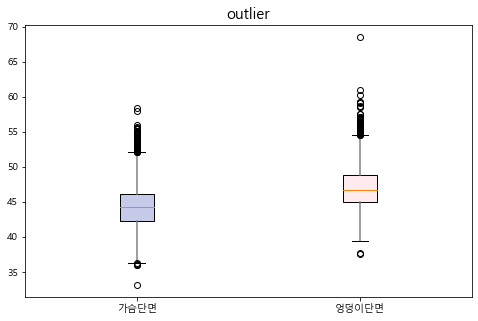

In [ ]:
#data_1 = size_2020_dt['어깨너비']
data_2 = size_2020_dt['가슴단면']
data_3 = size_2020_dt['엉덩이단면']
data = [data_2, data_3]


fig = plt.figure(figsize =(8, 5))
ax = fig.add_subplot(111)
 
# Creating axes instance
bp = ax.boxplot(data, patch_artist = True, vert = 1)

#박스플롯 상자 안 색깔
colors = ['#c5cae9', '#ffebee']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    
#박스플롯 1q,3q 사이 실선 색깔 
#changing color and linewidth of
#whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='grey',
                linewidth = 1.5)

     
# x-axis labels
ax.set_xticklabels(['가슴단면', '엉덩이단면'])
 
# Adding title
plt.title("outlier", fontsize=15)
 
# Removing top axes and right axes
# ticks

#y의 범위 제한
#ax.set_ylim(0,0.5)

# show plot
plt.show(bp)

#plt.savefig('outlier'+'.png')

<AxesSubplot:ylabel='어깨너비'>

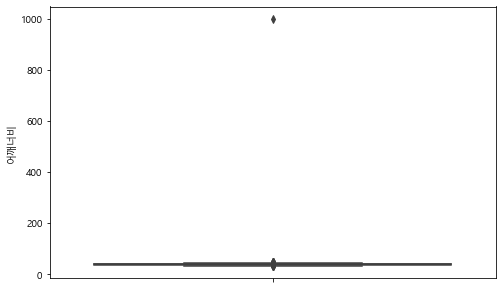

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(data = size_2020_dt, y = '어깨너비')

#### 이상치 제거 함수

In [ ]:
#이상치 제거 함수
def outliers_iqr(data):
    q1, q3 = np.percentile(data, [25, 75])
    
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    
    return np.where((data > upper_bound) | (data < lower_bound))

In [ ]:
shoulder_lead_outlier_index = outliers_iqr(size_2020_dt['어깨너비'])[0]
chest_lead_outlier_index = outliers_iqr(size_2020_dt['가슴단면'])[0]
hip_lead_outlier_index = outliers_iqr(size_2020_dt['엉덩이단면'])[0]

In [ ]:
size_2020_dt.loc[shoulder_lead_outlier_index, '어깨너비']

123      49.1
179      46.7
317      46.0
528      46.5
626      33.4
757      33.8
884     999.9
1068     46.8
1092     33.7
1246     33.2
1330     33.8
1378     47.0
1551     45.9
1963     33.0
1996     49.0
2057     49.5
2081     34.0
2595     46.5
2647     47.5
2676     46.1
Name: 어깨너비, dtype: float64

In [ ]:
size_2020_dt.loc[chest_lead_outlier_index, '가슴단면']

72      52.80
94      52.75
123     53.20
154     54.15
179     55.45
        ...  
2210    54.90
2223    55.00
2539    36.25
2661    54.95
2723    52.50
Name: 가슴단면, Length: 62, dtype: float64

In [ ]:
size_2020_dt.loc[hip_lead_outlier_index, '엉덩이단면']

94      56.40
120     56.00
123     58.60
179     56.25
197     57.60
205     54.70
206     57.05
273     59.10
350     54.60
371     55.95
403     55.45
421     54.90
440     56.50
457     56.00
498     56.10
524     56.80
528     56.80
586     54.85
588     37.50
641     55.50
699     58.60
756     56.85
760     68.45
791     56.35
832     55.50
878     54.65
879     55.60
880     60.25
882     54.95
961     54.75
994     55.40
1008    54.85
1022    56.10
1070    55.75
1138    57.15
1189    54.85
1209    55.75
1248    56.95
1344    57.05
1669    59.25
1712    55.25
1981    54.65
2078    54.70
2095    54.90
2210    59.20
2264    55.05
2326    60.90
2365    56.70
2366    55.50
2404    55.85
2406    57.55
2408    55.05
2475    57.00
2586    54.60
2713    58.65
2723    55.20
2765    37.75
Name: 엉덩이단면, dtype: float64

In [ ]:
lead_outlier_index = np.concatenate((shoulder_lead_outlier_index,
                                     chest_lead_outlier_index,
                                     hip_lead_outlier_index ), axis=None)

print(len(lead_outlier_index))
lead_outlier_index

139


array([ 123,  179,  317,  528,  626,  757,  884, 1068, 1092, 1246, 1330,
       1378, 1551, 1963, 1996, 2057, 2081, 2595, 2647, 2676,   72,   94,
        123,  154,  179,  273,  317,  444,  457,  498,  524,  528,  640,
        641,  650,  699,  741,  760,  772,  791,  832,  845,  879,  880,
        882,  954,  961,  976, 1016, 1022, 1049, 1059, 1068, 1070, 1098,
       1111, 1138, 1164, 1171, 1209, 1248, 1262, 1344, 1357, 1378, 1461,
       1475, 1478, 1571, 1669, 1692, 1699, 1712, 1780, 1835, 1887, 2058,
       2210, 2223, 2539, 2661, 2723,   94,  120,  123,  179,  197,  205,
        206,  273,  350,  371,  403,  421,  440,  457,  498,  524,  528,
        586,  588,  641,  699,  756,  760,  791,  832,  878,  879,  880,
        882,  961,  994, 1008, 1022, 1070, 1138, 1189, 1209, 1248, 1344,
       1669, 1712, 1981, 2078, 2095, 2210, 2264, 2326, 2365, 2366, 2404,
       2406, 2408, 2475, 2586, 2713, 2723, 2765], dtype=int64)

In [ ]:
lead_not_outlier_index = []

for i in size_2020_dt.index:
    if i not in lead_outlier_index:
        lead_not_outlier_index.append(i)

In [ ]:
size_2020_dt = size_2020_dt.loc[lead_not_outlier_index]
size_2020_dt = size_2020_dt.reset_index(drop=True)
size_2020_dt

,어깨너비,가슴단면,엉덩이단면
0,38.6,49.65,49.90
1,37.5,40.90,46.10
2,39.5,41.95,44.70
3,36.6,43.35,46.40
4,37.7,45.10,45.45
...,...,...,...
2662,35.8,41.60,46.10
2663,40.0,39.45,43.35
2664,38.0,47.10,52.95
2665,40.5,43.40,49.40


In [ ]:
size_2020_dt.to_csv("C:/Users/AB350/#실습(221031~221111)/sizekorea_2020.csv")

In [ ]:
sizekorea_2020 = pd.read_csv("C:/Users/AB350/#실습(221031~221111)/sizekorea_2020.csv")

## 3) 무신사 사이즈 데이터로 사이즈 코리아 데이터 사이즈 분류

* 무신사 데이터 (사이즈 표기 정리한 것)

In [ ]:
musinsa_dress_data_3_edit

,values,size,measures,brand_name,product_name
0,33.0,XS,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
1,43.5,XS,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
2,45.0,XS,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
3,34.0,S,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
4,46.0,S,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
4552,46.0,S,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
4553,47.0,S,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
4554,35.0,M,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
4555,48.5,M,가슴단면,LIENLIER,로즈퍼프원피스 - 카키


In [ ]:
musinsa_dress_data_3_edit.query("size == 'XS'")

,values,size,measures,brand_name,product_name
0,33.0,XS,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
1,43.5,XS,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
2,45.0,XS,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
36,33.0,XS,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
37,43.5,XS,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
4540,43.5,XS,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
4541,45.0,XS,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
4548,33.0,XS,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
4549,43.5,XS,가슴단면,LIENLIER,로즈퍼프원피스 - 카키


In [ ]:
dress_XS = musinsa_dress_data_3_edit.query("size == 'XS'")
dress_S = musinsa_dress_data_3_edit.query("size == 'S'")
dress_M = musinsa_dress_data_3_edit.query("size == 'M'")
dress_Free = musinsa_dress_data_3_edit.query("size == 'Free'")
dress_L = musinsa_dress_data_3_edit.query("size == 'L'")
dress_XL = musinsa_dress_data_3_edit.query("size == 'XL'")

#어깨너비
print('어깨너비')
print('XS:', np.round(dress_XS.query("measures == '어깨너비'")['values'].mean(), 3))
print('S:', np.round(dress_S.query("measures == '어깨너비'")['values'].mean(), 3))
print('M:', np.round(dress_M.query("measures == '어깨너비'")['values'].mean(), 3))
print('Free:', np.round(dress_Free.query("measures == '어깨너비'")['values'].mean(), 3))
print('L:', np.round(dress_L.query("measures == '어깨너비'")['values'].mean(), 3))
print('XL:', np.round(dress_XL.query("measures == '어깨너비'")['values'].mean(), 3))
print()

#가슴단면
print('가슴단면')
print('XS:', np.round(dress_XS.query("measures == '가슴단면'")['values'].mean(), 3))
print('S:', np.round(dress_S.query("measures == '가슴단면'")['values'].mean(), 3))
print('M:', np.round(dress_M.query("measures == '가슴단면'")['values'].mean(), 3))
print('Free:', np.round(dress_Free.query("measures == '가슴단면'")['values'].mean(), 3))
print('L_:', np.round(dress_L.query("measures == '가슴단면'")['values'].mean(), 3))
print('XL:', np.round(dress_XL.query("measures == '가슴단면'")['values'].mean(), 3))
print()

#엉덩이단면
print('엉덩이단면')
print('XS:', np.round(dress_XS.query("measures == '엉덩이단면'")['values'].mean(), 3))
print('S:', np.round(dress_S.query("measures == '엉덩이단면'")['values'].mean(), 3))
print('M:', np.round(dress_M.query("measures == '엉덩이단면'")['values'].mean(), 3))
print('Free:', np.round(dress_Free.query("measures == '엉덩이단면'")['values'].mean(), 3))
print('L:', np.round(dress_L.query("measures == '엉덩이단면'")['values'].mean(), 3))
print('XL:', np.round(dress_XL.query("measures == '엉덩이단면'")['values'].mean(), 3))

어깨너비
XS: 34.232
S: 37.009
M: 38.344
Free: 40.694
L: 42.065
XL: 44.5

가슴단면
XS: 43.344
S: 45.289
M: 48.449
Free: 48.719
L_: 49.183
XL: 53.1

엉덩이단면
XS: 46.041
S: 49.276
M: 51.161
Free: 57.388
L: 53.393
XL: 58.3


* 사이즈 코리아 데이터

In [ ]:
sizekorea_2020 = pd.read_csv("C:/Users/AB350/#실습(221031~221111)/sizekorea_2020.csv").iloc[:, 1:]
sizekorea_2020

,어깨너비,가슴단면,엉덩이단면
0,38.6,49.65,49.90
1,37.5,40.90,46.10
2,39.5,41.95,44.70
3,36.6,43.35,46.40
4,37.7,45.10,45.45
...,...,...,...
2662,35.8,41.60,46.10
2663,40.0,39.45,43.35
2664,38.0,47.10,52.95
2665,40.5,43.40,49.40


In [ ]:
#무신사 데이터의 어깨너비
print('어깨너비')
print('XS:', np.round(dress_XS.query("measures == '어깨너비'")['values'].mean(), 3))
print('S:', np.round(dress_S.query("measures == '어깨너비'")['values'].mean(), 3))
print('M:', np.round(dress_M.query("measures == '어깨너비'")['values'].mean(), 3))
print('Free:', np.round(dress_Free.query("measures == '어깨너비'")['values'].mean(), 3))
print('L:', np.round(dress_L.query("measures == '어깨너비'")['values'].mean(), 3))
print('XL:', np.round(dress_XL.query("measures == '어깨너비'")['values'].mean(), 3))

어깨너비
XS: 34.232
S: 37.009
M: 38.344
Free: 40.694
L: 42.065
XL: 44.5


In [ ]:
sizekorea_2020_shoulder = sizekorea_2020.copy()

In [ ]:
#무신사 데이터의 각 사이즈별 어깨너비의 평균값을 기준으로 사이즈 코리아 데이터 분류
sizekorea_2020_shoulder['size'] = np.random.randint(2667)
size_lst = []

for i in range(2667):
    if sizekorea_2020_shoulder['어깨너비'][i] <= 34.232:
        size_lst.append('XS')
    
    elif sizekorea_2020_shoulder['어깨너비'][i] <= 37.009:
        size_lst.append('S')
        
    elif sizekorea_2020_shoulder['어깨너비'][i] <= 38.344:
        size_lst.append('M')
        
    elif sizekorea_2020_shoulder['어깨너비'][i] <= 40.694:
        size_lst.append('Free')
        
    elif sizekorea_2020_shoulder['어깨너비'][i] <= 42.065:
        size_lst.append('L')
        
    else:
        size_lst.append('XL')
        
#print(size_lst)
#print()

sizekorea_2020_shoulder['size'] = size_lst

sizekorea_2020_shoulder

,어깨너비,가슴단면,엉덩이단면,size
0,38.6,49.65,49.90,Free
1,37.5,40.90,46.10,M
2,39.5,41.95,44.70,Free
3,36.6,43.35,46.40,S
4,37.7,45.10,45.45,M
...,...,...,...,...
2662,35.8,41.60,46.10,S
2663,40.0,39.45,43.35,Free
2664,38.0,47.10,52.95,M
2665,40.5,43.40,49.40,Free


In [ ]:
sizekorea_2020_shoulder['size'].value_counts()

Free    1128
L        535
M        438
XL       340
S        226
Name: size, dtype: int64

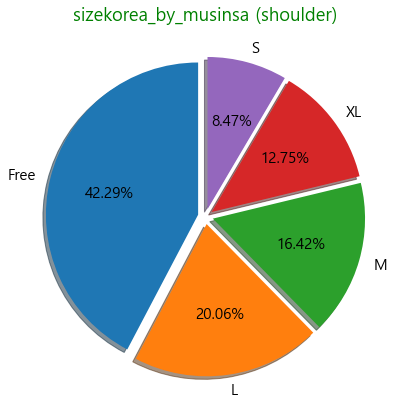

In [ ]:
plt.figure(figsize=(7,7))

# pie chart 만들기(차트 띄우기, labels 달기, 각 조정, 그림자, 값 소숫점 표시)
plt.pie(sizekorea_2020_shoulder['size'].value_counts(), labels=('Free', 'L', 'M', 'XL', 'S'), startangle=90, autopct='%.2f%%',
        explode=[0.05, 0.05, 0.05, 0.05, 0.05], shadow=True, pctdistance=0.6)

# 라벨, 타이틀 달기
plt.title('sizekorea_by_musinsa (shoulder)', fontsize=18, color='g')

#plt.legend(['XS', 'M', 'S', 'XL', 'Free', 'L'], loc='upper right')

plt.rc('font', size=15)

plt.show()

#plt.savefig('sizekorea_chest_cm.jpg')
#plt.savefig('sizekorea_chest_cm.png')

<AxesSubplot:xlabel='어깨너비', ylabel='Density'>

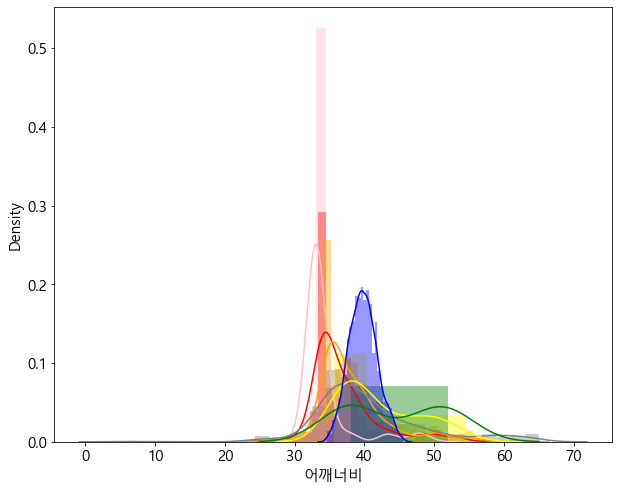

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

sns.distplot(dress_XS.query("measures == '어깨너비'")['values'], color='pink')
sns.distplot(dress_S.query("measures == '어깨너비'")['values'], color='red')
sns.distplot(dress_M.query("measures == '어깨너비'")['values'], color='orange')
sns.distplot(dress_Free.query("measures == '어깨너비'")['values'], color='gray')
sns.distplot(dress_L.query("measures == '어깨너비'")['values'], color='yellow')
sns.distplot(dress_XL.query("measures == '어깨너비'")['values'], color='green')
sns.distplot(sizekorea_2020_shoulder['어깨너비'], color='blue')

#plt.savefig('mini_dress_total_length.png')

## 4) 사이즈코리아 데이터 군집화(1) : K-Means
features : 키, 어깨너비, 가슴둘레, 허리둘레, 엉덩이둘레<br>
'2020_size_measures.csv' 파일은 20세 이상 성인에 대한 데이터이다<br>
002. 키 , 059. 어깨사이길이 , 041. 가슴둘레 , 045. 허리둘레 , 048. 엉덩이둘레 ,

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math

* 군집화 함수

In [ ]:
def visualize_silhouette(cluster_lists, X_features): 
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 계수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 계수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [ ]:
sizekorea_2020 = pd.read_csv("C:/Users/AB350/#실습(221031~221111)/sizekorea_2020.csv").iloc[:, 1:]
sizekorea_2020

,어깨너비,가슴단면,엉덩이단면
0,38.6,49.65,49.90
1,37.5,40.90,46.10
2,39.5,41.95,44.70
3,36.6,43.35,46.40
4,37.7,45.10,45.45
...,...,...,...
2662,35.8,41.60,46.10
2663,40.0,39.45,43.35
2664,38.0,47.10,52.95
2665,40.5,43.40,49.40


In [ ]:
sk_2020_km = sizekorea_2020.copy()

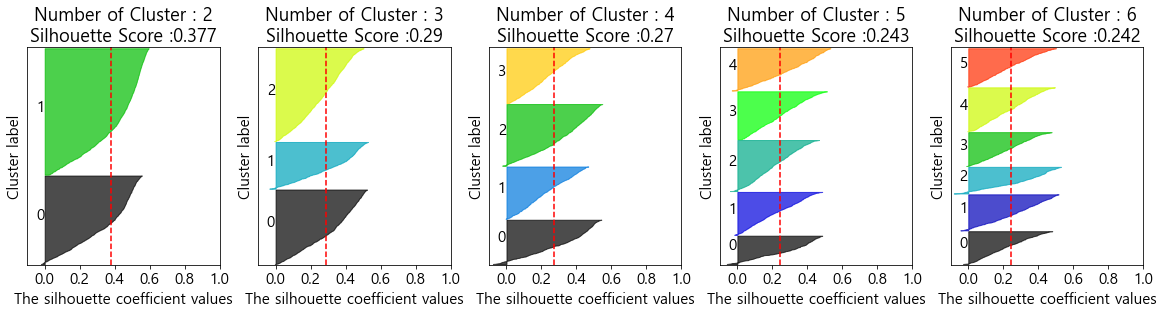

In [ ]:
cluster_lists = [2,3,4,5,6]
X_features = sk_2020_km

visualize_silhouette(cluster_lists, X_features)

#plt.savefig('clustering_result.jpg')
#plt.savefig('clustering_result.png')

### ① n_clusters = 4 (silhouette_score 0.27)

In [ ]:
sk_2020_km4 = sk_2020_km.copy()

In [ ]:
#n_clusters = 4
clusterer = KMeans(n_clusters = 4, max_iter=500, random_state=0)
cluster_labels = clusterer.fit(sk_2020_km4)
cluster_labels.labels_

array([0, 2, 2, ..., 0, 1, 3])

In [ ]:
sk_2020_km4['cluster4_labels'] = cluster_labels.labels_
sk_2020_km4

,어깨너비,가슴단면,엉덩이단면,cluster4_labels
0,38.6,49.65,49.90,0
1,37.5,40.90,46.10,2
2,39.5,41.95,44.70,2
3,36.6,43.35,46.40,3
4,37.7,45.10,45.45,3
...,...,...,...,...
2662,35.8,41.60,46.10,2
2663,40.0,39.45,43.35,2
2664,38.0,47.10,52.95,0
2665,40.5,43.40,49.40,1


In [ ]:
#각 데이터 포인트의 실루엣 계수
sil_values = silhouette_samples(np.array(sk_2020_km), sk_2020_km4['cluster4_labels'])

#모든 데이터의 평균 실루엣 계수
sil_avg = silhouette_score(np.array(sk_2020_km), sk_2020_km4['cluster4_labels']).round(3)

print('sil_values:', sil_values)
print('sil_avg:', sil_avg)

sil_values: [0.31526226 0.2832067  0.37511465 ... 0.27418737 0.22960381 0.12741008]
sil_avg: 0.27


#### 군집화 결과 파이차트 시각화

In [ ]:
sk_2020_km4.groupby('cluster4_labels')[['어깨너비', '가슴단면', '엉덩이단면']].mean().round(2)

,어깨너비,가슴단면,엉덩이단면
cluster4_labels,,,
0,41.33,48.01,50.46
1,41.35,43.97,47.06
2,38.75,41.15,44.16
3,38.25,44.81,46.72


In [ ]:
sk_2020_km4['cluster4_labels'].value_counts()

2    771
3    687
1    655
0    554
Name: cluster4_labels, dtype: int64

0 : 3-4-4 => 11/4 (554, XL)<br>
1 : 4-2-3 => 9/3 (655, L)<br>
2 : 2-1-1 => 4/1 (771, S)<br>
3 : 1-3-2 => 6/2 (687, M)

In [ ]:
sk_2020_km4

,어깨너비,가슴단면,엉덩이단면,cluster4_labels
0,38.6,49.65,49.90,0
1,37.5,40.90,46.10,2
2,39.5,41.95,44.70,2
3,36.6,43.35,46.40,3
4,37.7,45.10,45.45,3
...,...,...,...,...
2662,35.8,41.60,46.10,2
2663,40.0,39.45,43.35,2
2664,38.0,47.10,52.95,0
2665,40.5,43.40,49.40,1


* 군집화 결과로 사이즈 표기 (n_clusters = 4)<br>
0 -> XL / 1 -> L / 2 -> S / 3 -> M

In [ ]:
sk_2020_km4['size(km4)'] = np.random.randint(2667)
size_li = []

for i in range(2667):
    if sk_2020_km4['cluster4_labels'][i] == 0:
        size_li.append('XL')
        
    elif sk_2020_km4['cluster4_labels'][i] == 1:
        size_li.append('L')
        
    elif sk_2020_km4['cluster4_labels'][i] == 2:
        size_li.append('S')
        
    else:
        size_li.append('M')
        
#print(size_lst)
#print()

sk_2020_km4['size(km4)'] = size_li

sk_2020_km4

,어깨너비,가슴단면,엉덩이단면,cluster4_labels,size(km4)
0,38.6,49.65,49.90,0,XL
1,37.5,40.90,46.10,2,S
2,39.5,41.95,44.70,2,S
3,36.6,43.35,46.40,3,M
4,37.7,45.10,45.45,3,M
...,...,...,...,...,...
2662,35.8,41.60,46.10,2,S
2663,40.0,39.45,43.35,2,S
2664,38.0,47.10,52.95,0,XL
2665,40.5,43.40,49.40,1,L


In [ ]:
sk_2020_km4['size(km4)'].value_counts()

S     771
M     687
L     655
XL    554
Name: size(km4), dtype: int64

In [ ]:
sk_2020_km4.groupby('size(km4)')[['size(km4)']].count()

,size(km4)
size(km4),
L,655
M,687
S,771
XL,554


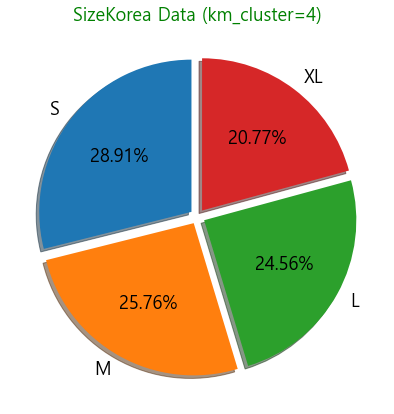

In [ ]:
plt.figure(figsize=(7,7))

# pie chart 만들기(차트 띄우기, labels 달기, 각 조정, 그림자, 값 소숫점 표시)
plt.pie(sk_2020_km4['size(km4)'].value_counts(), labels=('S', 'M', 'L', 'XL'), startangle=90, autopct='%.2f%%',
       explode=[0.05, 0.05, 0.05, 0.05], shadow=True)

# 라벨, 타이틀 달기
plt.title('SizeKorea Data (km_cluster=4)', fontsize=18, color='g')

#plt.legend(['M','L', 'S', 'XL'], loc='upper right')

plt.rc('font', size=18)

plt.show()

#plt.savefig('SizeKorea_Data(cluster=4).png')
#plt.savefig('SizeKorea_Data(cluster=4).jpg')

* 군집화 결과 저장

In [ ]:
sk_2020_km4.to_csv("C:/Users/AB350/#실습(221031~221111)/sizekorea_2020_km4.csv")

### ② n_clusters = 5 (silhouette_score 0.243)

In [ ]:
sk_2020_km5 = sk_2020_km.copy()

In [ ]:
#n_clusters = 5
clusterer = KMeans(n_clusters = 5, max_iter=500, random_state=0)
cluster_labels = clusterer.fit(sk_2020_km5)
cluster_labels.labels_

array([0, 4, 4, ..., 0, 2, 2])

In [ ]:
sk_2020_km5['cluster5_labels'] = cluster_labels.labels_
sk_2020_km5

,어깨너비,가슴단면,엉덩이단면,cluster5_labels
0,38.6,49.65,49.90,0
1,37.5,40.90,46.10,4
2,39.5,41.95,44.70,4
3,36.6,43.35,46.40,3
4,37.7,45.10,45.45,3
...,...,...,...,...
2662,35.8,41.60,46.10,3
2663,40.0,39.45,43.35,4
2664,38.0,47.10,52.95,0
2665,40.5,43.40,49.40,2


각 데이터 포인트의 실루엣 계수<br>
sklearn.metrics.silhouette_samples(X, labels, metric='euclidean', **kwds)<br>
(X : X feature 데이터 세트, labels : 군집 레이블 값)<br>

전체 데이터의 실루엣 계수 값의 평균<br>
sklearn.metrics.silhouette_score(X, labels, metric='euclidean', sample_size=None, **kwds)

In [ ]:
#각 데이터 포인트의 실루엣 계수
sil_values = silhouette_samples(np.array(sk_2020_km), sk_2020_km5['cluster5_labels'])

#모든 데이터의 평균 실루엣 계수
sil_avg = silhouette_score(np.array(sk_2020_km), sk_2020_km5['cluster5_labels']).round(3)

print('sil_values:', sil_values)
print('sil_avg:', sil_avg)

sil_values: [0.10817561 0.12527974 0.08958651 ... 0.07279671 0.12719387 0.02284275]
sil_avg: 0.243


#### 군집화 결과 파이차트 시각화

In [ ]:
sk_2020_km5

,어깨너비,가슴단면,엉덩이단면,cluster5_labels
0,38.6,49.65,49.90,0
1,37.5,40.90,46.10,4
2,39.5,41.95,44.70,4
3,36.6,43.35,46.40,3
4,37.7,45.10,45.45,3
...,...,...,...,...
2662,35.8,41.60,46.10,3
2663,40.0,39.45,43.35,4
2664,38.0,47.10,52.95,0
2665,40.5,43.40,49.40,2


In [ ]:
sk_2020_km5.groupby('cluster5_labels')[['어깨너비', '가슴단면', '엉덩이단면']].mean().round(2)

,어깨너비,가슴단면,엉덩이단면
cluster5_labels,,,
0,41.80,48.70,51.08
1,41.21,42.87,46.14
2,40.22,45.88,48.47
3,38.07,44.09,45.94
4,38.45,40.67,43.76


In [ ]:
sk_2020_km5['cluster5_labels'].value_counts()

2    641
3    601
1    539
4    530
0    356
Name: cluster5_labels, dtype: int64

0 : 5-5-5 => 15/5 (356, XL)<br>
1 : 4-2-3 => 9/3 (539, F)<br>
2 : 3-4-4 => 11/4 (641, L)<br>
3 : 1-3-2 => 6/2 (601, M)<br>
4 : 2-1-1 => 4/1 (530, S)

* 군집화 결과로 사이즈 표기 (n_clusters = 5)<br>
0 -> XL / 1 -> Free / 2 -> L / 3 -> M / 4 -> S 

In [ ]:
sk_2020_km5['size(km5)'] = np.random.randint(2667)
size_li = []

for i in range(2667):
    if sk_2020_km5['cluster5_labels'][i] == 0:
        size_li.append('XL')
        
    elif sk_2020_km5['cluster5_labels'][i] == 1:
        size_li.append('Free')
        
    elif sk_2020_km5['cluster5_labels'][i] == 2:
        size_li.append('L')
        
    elif sk_2020_km5['cluster5_labels'][i] == 3:
        size_li.append('M')
        
    else:
        size_li.append('S')
        
#print(size_lst)
#print()

sk_2020_km5['size(km5)'] = size_li

sk_2020_km5

,어깨너비,가슴단면,엉덩이단면,cluster5_labels,size(km5)
0,38.6,49.65,49.90,0,XL
1,37.5,40.90,46.10,4,S
2,39.5,41.95,44.70,4,S
3,36.6,43.35,46.40,3,M
4,37.7,45.10,45.45,3,M
...,...,...,...,...,...
2662,35.8,41.60,46.10,3,M
2663,40.0,39.45,43.35,4,S
2664,38.0,47.10,52.95,0,XL
2665,40.5,43.40,49.40,2,L


In [ ]:
sk_2020_km5['size(km5)'].value_counts()

L       641
M       601
Free    539
S       530
XL      356
Name: size(km5), dtype: int64

In [ ]:
sk_2020_km5.groupby('cluster5_labels')[['cluster5_labels']].count()

,cluster5_labels
cluster5_labels,
0,356
1,539
2,641
3,601
4,530


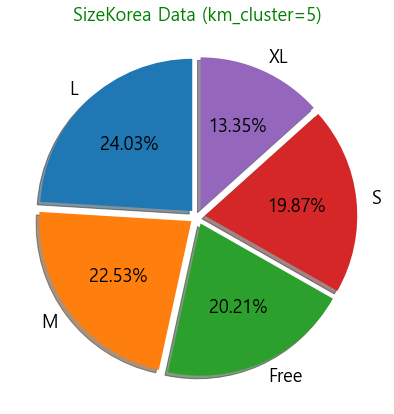

In [ ]:
plt.figure(figsize=(7,7))

# pie chart 만들기(차트 띄우기, labels 달기, 각 조정, 그림자, 값 소숫점 표시)
plt.pie(sk_2020_km5['size(km5)'].value_counts(), labels=('L', 'M', 'Free', 'S', 'XL'), startangle=90, autopct='%.2f%%',
       explode=[0.05, 0.05, 0.05, 0.05, 0.05], shadow=True)

# 라벨, 타이틀 달기
plt.title('SizeKorea Data (km_cluster=5)', fontsize=18, color='g')

#plt.legend(['M','L', 'S', 'XL'], loc='upper right')

plt.rc('font', size=18)

plt.show()

#plt.savefig('SizeKorea_Data(cluster=4).png')
#plt.savefig('SizeKorea_Data(cluster=4).jpg')

* 군집화 결과 저장

In [ ]:
sk_2020_km5.to_csv("C:/Users/AB350/#실습(221031~221111)/sizekorea_2020_km5.csv")

## 5) 사이즈코리아 데이터 군집화(2) : Mean-Shift

In [ ]:
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

In [ ]:
sk_2020_ms = sizekorea_2020.copy()
sk_2020_ms

,어깨너비,가슴단면,엉덩이단면
0,38.6,49.65,49.90
1,37.5,40.90,46.10
2,39.5,41.95,44.70
3,36.6,43.35,46.40
4,37.7,45.10,45.45
...,...,...,...
2662,35.8,41.60,46.10
2663,40.0,39.45,43.35
2664,38.0,47.10,52.95
2665,40.5,43.40,49.40


### * 최적의 대역폭 계산

In [ ]:
bandwidth = estimate_bandwidth(sk_2020_ms)
print('bandwidth 값:', round(bandwidth, 3))

bandwidth 값: 4.119


In [ ]:
best_bandwidth = estimate_bandwidth(sk_2020_ms)

meanshift = MeanShift(bandwidth=best_bandwidth)

cluster_labels = meanshift.fit_predict(sk_2020_ms)

sk_2020_ms['meanshift_label'] = cluster_labels

print(sk_2020_ms['meanshift_label'].value_counts())

centers = meanshift.cluster_centers_

unique_labels = np.unique(cluster_labels)

0    2667
Name: meanshift_label, dtype: int64


In [ ]:
sk_2020_ms.groupby('meanshift_label')[['어깨너비', '가슴단면', '엉덩이단면']].mean().round(2)

,어깨너비,가슴단면,엉덩이단면
meanshift_label,,,
0,39.79,44.21,46.84


In [ ]:
sk_2020_ms.groupby('meanshift_label')[['meanshift_label']].count()

,meanshift_label
meanshift_label,
0,2667


## 6) 사이즈코리아 데이터 군집화(3) : GMM

In [ ]:
from sklearn.mixture import GaussianMixture

In [ ]:
sk_2020_gm = sizekorea_2020.copy()
sk_2020_gm

,어깨너비,가슴단면,엉덩이단면
0,38.6,49.65,49.90
1,37.5,40.90,46.10
2,39.5,41.95,44.70
3,36.6,43.35,46.40
4,37.7,45.10,45.45
...,...,...,...
2662,35.8,41.60,46.10
2663,40.0,39.45,43.35
2664,38.0,47.10,52.95
2665,40.5,43.40,49.40


### ① n_components=6

In [ ]:
sk_2020_gm6 = sk_2020_gm.copy()
sk_2020_gm6

,어깨너비,가슴단면,엉덩이단면
0,38.6,49.65,49.90
1,37.5,40.90,46.10
2,39.5,41.95,44.70
3,36.6,43.35,46.40
4,37.7,45.10,45.45
...,...,...,...
2662,35.8,41.60,46.10
2663,40.0,39.45,43.35
2664,38.0,47.10,52.95
2665,40.5,43.40,49.40


In [ ]:
# gmm으로 군집화
gmm = GaussianMixture(n_components=6, random_state=0).fit(sk_2020_gm6)
gmm_cluster_labels = gmm.predict(sk_2020_gm6)

# 클러스터링 결과 저장
sk_2020_gm6['gmm_cluster6_labels'] = gmm_cluster_labels

# target 값에 따라서 gmm_cluster 값이 어떻게 매핑되었는지 확인
sk_2020_gm6['gmm_cluster6_labels'].value_counts()

4    575
1    460
5    440
0    422
3    421
2    349
Name: gmm_cluster6_labels, dtype: int64

In [ ]:
sk_2020_gm6.groupby('gmm_cluster6_labels')[['어깨너비', '가슴단면', '엉덩이단면']].mean().round(2)

,어깨너비,가슴단면,엉덩이단면
gmm_cluster6_labels,,,
0,38.90,45.95,48.75
1,38.36,40.52,43.57
2,41.78,48.84,50.95
3,41.69,45.33,47.53
4,38.43,44.01,45.45
5,40.54,41.94,46.32


0 : 3-5-5 => 13/5 (422, L)<br>
1 : 1-1-1 => 3/1 (460, XS)<br>
2 : 6-6-6 => 18/6 (349, XL)<br>
3 : 5-4-4 => 13/4 (421, F)<br>
4 : 2-3-2 => 7/2 (575, S)<br>
5 : 4-2-3 => 9/3 (440, M)

#### 군집화 결과 파이차트 시각화

* 군집화 결과로 사이즈 표기 (n_clusters = 5)<br>
0 -> L / 1 -> XS / 2 -> XL / 3 -> Free(M~L) / 4 -> S / 5 -> M

In [ ]:
sk_2020_gm6['size(gmm6)'] = np.random.randint(2667)
size_li = []

for i in range(2667):
    if sk_2020_gm6['gmm_cluster6_labels'][i] == 0:
        size_li.append('L')
        
    elif sk_2020_gm6['gmm_cluster6_labels'][i] == 1:
        size_li.append('XS')
        
    elif sk_2020_gm6['gmm_cluster6_labels'][i] == 2:
        size_li.append('XL')
        
    elif sk_2020_gm6['gmm_cluster6_labels'][i] == 3:
        size_li.append('Free')
        
    elif sk_2020_gm6['gmm_cluster6_labels'][i] == 4:
        size_li.append('S')
        
    else:
        size_li.append('M')
        
#print(size_lst)
#print()

sk_2020_gm6['size(gmm6)'] = size_li

sk_2020_gm6

,어깨너비,가슴단면,엉덩이단면,gmm_cluster6_labels,size(gmm6)
0,38.6,49.65,49.90,2,XL
1,37.5,40.90,46.10,1,XS
2,39.5,41.95,44.70,1,XS
3,36.6,43.35,46.40,4,S
4,37.7,45.10,45.45,4,S
...,...,...,...,...,...
2662,35.8,41.60,46.10,1,XS
2663,40.0,39.45,43.35,1,XS
2664,38.0,47.10,52.95,2,XL
2665,40.5,43.40,49.40,0,L


In [ ]:
sk_2020_gm6['size(gmm6)'].value_counts()

S       575
XS      460
M       440
L       422
Free    421
XL      349
Name: size(gmm6), dtype: int64

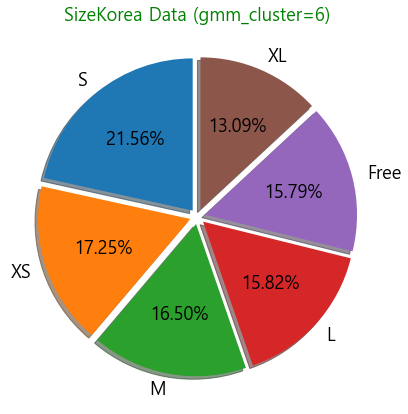

In [ ]:
plt.figure(figsize=(7,7))

# pie chart 만들기(차트 띄우기, labels 달기, 각 조정, 그림자, 값 소숫점 표시)
plt.pie(sk_2020_gm6['size(gmm6)'].value_counts(), labels=('S', 'XS', 'M', 'L', 'Free', 'XL'), startangle=90, autopct='%.2f%%',
       explode=[0.05, 0.05, 0.05, 0.05, 0.05, 0.05], shadow=True)

# 라벨, 타이틀 달기
plt.title('SizeKorea Data (gmm_cluster=6)', fontsize=18, color='g')

#plt.legend(['M','L', 'S', 'XL'], loc='upper right')

plt.rc('font', size=18)

plt.show()

#plt.savefig('SizeKorea_Data(gmm_cluster=6).png')
#plt.savefig('SizeKorea_Data(gmm_cluster=6).jpg')

* 군집화 결과 저장

In [ ]:
sk_2020_gm6.to_csv("C:/Users/AB350/#실습(221031~221111)/sizekorea_2020_gmm6.csv")

### ② n_components=5

In [ ]:
sk_2020_gm5 = sk_2020_gm.copy()
sk_2020_gm5

,어깨너비,가슴단면,엉덩이단면
0,38.6,49.65,49.90
1,37.5,40.90,46.10
2,39.5,41.95,44.70
3,36.6,43.35,46.40
4,37.7,45.10,45.45
...,...,...,...
2662,35.8,41.60,46.10
2663,40.0,39.45,43.35
2664,38.0,47.10,52.95
2665,40.5,43.40,49.40


In [ ]:
# gmm으로 군집화
gmm = GaussianMixture(n_components=5, random_state=0).fit(sk_2020_gm5)
gmm_cluster_labels = gmm.predict(sk_2020_gm5)

# 클러스터링 결과 저장
sk_2020_gm5['gmm_cluster5_labels'] = gmm_cluster_labels

# target 값에 따라서 gmm_cluster 값이 어떻게 매핑되었는지 확인
sk_2020_gm5['gmm_cluster5_labels'].value_counts()

0    599
3    593
4    589
1    492
2    394
Name: gmm_cluster5_labels, dtype: int64

In [ ]:
sk_2020_gm5.groupby('gmm_cluster5_labels')[['어깨너비', '가슴단면', '엉덩이단면']].mean().round(2)

,어깨너비,가슴단면,엉덩이단면
gmm_cluster5_labels,,,
0,38.16,45.01,46.47
1,38.14,40.65,43.74
2,41.60,48.71,50.78
3,41.10,45.25,48.21
4,40.32,42.32,45.79


0 : 2-3-3 => 3 (599, F)<br>
1 : 1-1-1 => 1 (492, S)<br>
2 : 5-5-5 => 5 (394, XL)<br>
3 : 4-4-4 => 4 (593, L)<br>
4 : 3-2-2 => 2 (589, M)

#### 군집화 결과 파이차트 시각화

* 군집화 결과로 사이즈 표기 (n_clusters = 5)<br>
0 -> Free(M~L) / 1 -> S / 2 -> XL / 3 -> L / 4 -> M

In [ ]:
sk_2020_gm5['size(gmm5)'] = np.random.randint(2667)
size_li = []

for i in range(2667):
    if sk_2020_gm5['gmm_cluster5_labels'][i] == 0:
        size_li.append('Free')
        
    elif sk_2020_gm5['gmm_cluster5_labels'][i] == 1:
        size_li.append('S')
        
    elif sk_2020_gm5['gmm_cluster5_labels'][i] == 2:
        size_li.append('XL')
        
    elif sk_2020_gm5['gmm_cluster5_labels'][i] == 3:
        size_li.append('L')
        
    else:
        size_li.append('M')
        
#print(size_lst)
#print()

sk_2020_gm5['size(gmm5)'] = size_li

sk_2020_gm5

,어깨너비,가슴단면,엉덩이단면,gmm_cluster5_labels,size(gmm5)
0,38.6,49.65,49.90,2,XL
1,37.5,40.90,46.10,1,S
2,39.5,41.95,44.70,4,M
3,36.6,43.35,46.40,0,Free
4,37.7,45.10,45.45,0,Free
...,...,...,...,...,...
2662,35.8,41.60,46.10,1,S
2663,40.0,39.45,43.35,1,S
2664,38.0,47.10,52.95,2,XL
2665,40.5,43.40,49.40,3,L


In [ ]:
sk_2020_gm5['size(gmm5)'].value_counts()

Free    599
L       593
M       589
S       492
XL      394
Name: size(gmm5), dtype: int64

In [ ]:
sk_2020_gm5.groupby('size(gmm5)')[['size(gmm5)']].count()

,size(gmm5)
size(gmm5),
Free,599
L,593
M,589
S,492
XL,394


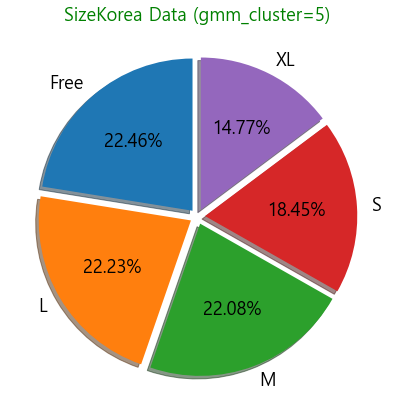

In [ ]:
plt.figure(figsize=(7,7))

# pie chart 만들기(차트 띄우기, labels 달기, 각 조정, 그림자, 값 소숫점 표시)
plt.pie(sk_2020_gm5['size(gmm5)'].value_counts(), labels=('Free', 'L', 'M', 'S', 'XL'), startangle=90, autopct='%.2f%%',
       explode=[0.05, 0.05, 0.05, 0.05, 0.05], shadow=True)

# 라벨, 타이틀 달기
plt.title('SizeKorea Data (gmm_cluster=5)', fontsize=18, color='g')

#plt.legend(['M','L', 'S', 'XL'], loc='upper right')

plt.rc('font', size=18)

plt.show()

#plt.savefig('SizeKorea_Data(gmm_cluster=6).png')
#plt.savefig('SizeKorea_Data(gmm_cluster=6).jpg')

* 군집화 결과 저장

In [ ]:
sk_2020_gm5.to_csv("C:/Users/AB350/#실습(221031~221111)/sizekorea_2020_gmm5.csv")

### ③ n_components=4

In [ ]:
sk_2020_gm4 = sk_2020_gm.copy()
sk_2020_gm4

,어깨너비,가슴단면,엉덩이단면
0,38.6,49.65,49.90
1,37.5,40.90,46.10
2,39.5,41.95,44.70
3,36.6,43.35,46.40
4,37.7,45.10,45.45
...,...,...,...
2662,35.8,41.60,46.10
2663,40.0,39.45,43.35
2664,38.0,47.10,52.95
2665,40.5,43.40,49.40


In [ ]:
# gmm으로 군집화
gmm = GaussianMixture(n_components=4, random_state=0).fit(sk_2020_gm4)
gmm_cluster_labels = gmm.predict(sk_2020_gm4)

# 클러스터링 결과 저장
sk_2020_gm4['gmm_cluster4_labels'] = gmm_cluster_labels

# target 값에 따라서 gmm_cluster 값이 어떻게 매핑되었는지 확인
sk_2020_gm4['gmm_cluster4_labels'].value_counts()

1    852
0    688
3    573
2    554
Name: gmm_cluster4_labels, dtype: int64

In [ ]:
sk_2020_gm4.groupby('gmm_cluster4_labels')[['어깨너비', '가슴단면', '엉덩이단면']].mean().round(2)

,어깨너비,가슴단면,엉덩이단면
gmm_cluster4_labels,,,
0,38.40,44.94,46.63
1,38.75,41.23,44.45
2,41.45,47.94,50.48
3,41.43,44.17,47.13


0 : 1-3-2 => 6/2 (688, M)<br>
1 : 2-1-1 => 4/1 (852, S)<br>
2 : 4-4-4 => 12/4 (554, XL)<br>
3 : 3-2-3 => 8/3 (573, L)

#### 군집화 결과 파이차트 시각화

* 군집화 결과로 사이즈 표기 (n_clusters = 4)<br>
0 -> M / 1 -> S / 2 -> XL / 3 -> L

In [ ]:
sk_2020_gm4['size(gmm4)'] = np.random.randint(2667)
size_li = []

for i in range(2667):
    if sk_2020_gm4['gmm_cluster4_labels'][i] == 0:
        size_li.append('M')
        
    elif sk_2020_gm4['gmm_cluster4_labels'][i] == 1:
        size_li.append('S')
        
    elif sk_2020_gm4['gmm_cluster4_labels'][i] == 2:
        size_li.append('XL')
        
    else:
        size_li.append('L')
        
#print(size_lst)
#print()

sk_2020_gm4['size(gmm4)'] = size_li

sk_2020_gm4

,어깨너비,가슴단면,엉덩이단면,gmm_cluster4_labels,size(gmm4)
0,38.6,49.65,49.90,2,XL
1,37.5,40.90,46.10,1,S
2,39.5,41.95,44.70,1,S
3,36.6,43.35,46.40,0,M
4,37.7,45.10,45.45,0,M
...,...,...,...,...,...
2662,35.8,41.60,46.10,1,S
2663,40.0,39.45,43.35,1,S
2664,38.0,47.10,52.95,2,XL
2665,40.5,43.40,49.40,3,L


In [ ]:
sk_2020_gm4['size(gmm4)'].value_counts()

S     852
M     688
L     573
XL    554
Name: size(gmm4), dtype: int64

In [ ]:
sk_2020_gm4.groupby('size(gmm4)')[['size(gmm4)']].count()

,size(gmm4)
size(gmm4),
L,573
M,688
S,852
XL,554


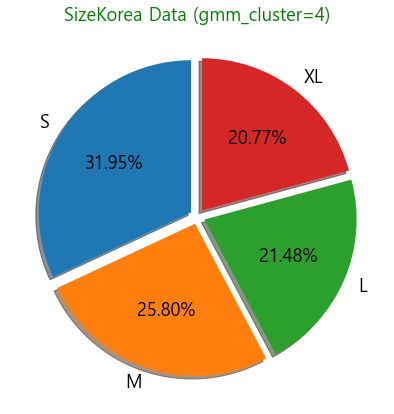

In [ ]:
plt.figure(figsize=(7,7))

# pie chart 만들기(차트 띄우기, labels 달기, 각 조정, 그림자, 값 소숫점 표시)
plt.pie(sk_2020_gm4['size(gmm4)'].value_counts(), labels=('S', 'M', 'L', 'XL'), startangle=90, autopct='%.2f%%',
       explode=[0.05, 0.05, 0.05, 0.05], shadow=True)

# 라벨, 타이틀 달기
plt.title('SizeKorea Data (gmm_cluster=4)', fontsize=18, color='g')

#plt.legend(['M','L', 'S', 'XL'], loc='upper right')

plt.rc('font', size=18)

plt.show()

#plt.savefig('SizeKorea_Data(gmm_cluster=6).png')
#plt.savefig('SizeKorea_Data(gmm_cluster=6).jpg')

* 군집화 결과 저장

In [ ]:
sk_2020_gm4.to_csv("C:/Users/AB350/#실습(221031~221111)/sizekorea_2020_gmm4.csv")

## 7) 사이즈코리아 데이터 군집화(4) : DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
sk_2020_db = sizekorea_2020.copy()
sk_2020_db

,어깨너비,가슴단면,엉덩이단면
0,38.6,49.65,49.90
1,37.5,40.90,46.10
2,39.5,41.95,44.70
3,36.6,43.35,46.40
4,37.7,45.10,45.45
...,...,...,...
2662,35.8,41.60,46.10
2663,40.0,39.45,43.35
2664,38.0,47.10,52.95
2665,40.5,43.40,49.40


In [ ]:
sk_2020_db = sizekorea_2020.copy()

# 주변 영역 반경 = 0.6, 최소 데이터 개수 = 8
dbscan = DBSCAN(eps=0.6, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(sk_2020_db)

# 군집화된 레이블 값 저장
sk_2020_db['dbscan_cluster'] = dbscan_labels

# 예측 비교
sk_2020_db['dbscan_cluster'].value_counts()

-1     1259
 0     1211
 4       20
 8       17
 5       14
 16      12
 17      11
 14      11
 2       10
 12      10
 1        9
 6        9
 9        9
 7        9
 3        8
 13       8
 18       8
 19       8
 20       8
 15       6
 10       6
 11       4
Name: dbscan_cluster, dtype: int64

In [ ]:
sk_2020_db = sizekorea_2020.copy()

# 주변 영역 반경 = 0.3, 최소 데이터 개수 = 3
dbscan = DBSCAN(eps=0.3, min_samples=3, metric='euclidean')
dbscan_labels = dbscan.fit_predict(sk_2020_db)

# 군집화된 레이블 값 저장
sk_2020_db['dbscan_cluster'] = dbscan_labels

# 예측 비교
sk_2020_db['dbscan_cluster'].value_counts()

-1      2053
 11       17
 5        13
 54       13
 34       13
        ... 
 45        3
 44        3
 113       3
 107       3
 127       3
Name: dbscan_cluster, Length: 143, dtype: int64

In [ ]:
sk_2020_db = sizekorea_2020.copy()

# 주변 영역 반경 = 0.8, 최소 데이터 개수 = 6
dbscan = DBSCAN(eps=0.8, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(sk_2020_db)

# 군집화된 레이블 값 저장
sk_2020_db['dbscan_cluster'] = dbscan_labels

# 예측 비교
sk_2020_db['dbscan_cluster'].value_counts()

 0    2041
-1     602
 3      10
 2       6
 4       6
 1       2
Name: dbscan_cluster, dtype: int64

In [ ]:
sk_2020_db.groupby('dbscan_cluster')[['dbscan_cluster']].count()

,dbscan_cluster
dbscan_cluster,
-1,602
0,2041
1,2
2,6
3,10
4,6


## 8) 분류(1) : Random Forest
사이즈 코리아 데이터 - train(0.8), 검증데이터(0.2)<br>
무신사 사이즈 데이터 - test<br>

사이즈 코리아 데이터로 학습/예측을 먼저 진행하여 적합한 분류 모델을 찾고,<br>
그것을 바탕으로 무신사 사이즈 데이터를 학습하여 레이블을 예측한다

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [ ]:
#예측 성능 평가 함수
def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion  = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average= "macro")
    recall = recall_score(y_test, pred, average= "macro")
    f1 = f1_score(y_test, pred, average= "macro")
    roc_auc = roc_auc_score(y_test, pred_proba, multi_class="ovo")

    print('오차행렬')
    print()
    print(confusion)
    print()
    print(f'정확도 : {accuracy}, 정밀도 : {precision}, 재현율 : {recall}, F1 : {f1}, AUC : {roc_auc}')

In [ ]:
def get_clf_eval1(y_test, pred = None):
    confusion  = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average= "macro")
    recall = recall_score(y_test, pred, average= "macro")
    f1 = f1_score(y_test, pred, average= "macro")
    
    print(f'정확도 : {accuracy.round(4)}, 정밀도 : {precision.round(4)}, 재현율 : {recall.round(4)}, F1 : {f1.round(4)}')

### ① 사이즈 코리아 데이터 (gmm_cluster = 5) 로 train, test set 만들기

In [ ]:
#sk_2020_gm5 = pd.read_csv("C:/Users/admin/#실습(221031~221111)/sizekorea_2020_gmm5.csv").iloc[:, 1:]
sk_2020_gm5

,어깨너비,가슴단면,엉덩이단면,gmm_cluster5_labels,size(gmm5)
0,38.6,49.65,49.90,2,XL
1,37.5,40.90,46.10,1,S
2,39.5,41.95,44.70,4,M
3,36.6,43.35,46.40,0,Free
4,37.7,45.10,45.45,0,Free
...,...,...,...,...,...
2662,35.8,41.60,46.10,1,S
2663,40.0,39.45,43.35,1,S
2664,38.0,47.10,52.95,2,XL
2665,40.5,43.40,49.40,3,L


In [ ]:
sk_2020_gm5.drop('size(gmm5)', axis=1, inplace=True)
sk_2020_gm5

,어깨너비,가슴단면,엉덩이단면,gmm_cluster5_labels
0,38.6,49.65,49.90,2
1,37.5,40.90,46.10,1
2,39.5,41.95,44.70,4
3,36.6,43.35,46.40,0
4,37.7,45.10,45.45,0
...,...,...,...,...
2662,35.8,41.60,46.10,1
2663,40.0,39.45,43.35,1
2664,38.0,47.10,52.95,2
2665,40.5,43.40,49.40,3


In [ ]:
sk_2020_gm5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2667 entries, 0 to 2666
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   어깨너비                 2667 non-null   float64
 1   가슴단면                 2667 non-null   float64
 2   엉덩이단면                2667 non-null   float64
 3   gmm_cluster5_labels  2667 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 83.5 KB


#### (gmm_cluster = 5) train set, test set

In [ ]:
np.array([x for x in sk_2020_gm5.iloc[5, :-1]])

array([39.4 , 43.75, 45.65])

In [ ]:
lst_2020_gm5 = []

for i in range(len(sk_2020_gm5)):
    lst1 = [x for x in sk_2020_gm5.iloc[i, :-1]]
    lst_2020_gm5.append(lst1)
    
lst_2020_gm5

[[38.6, 49.650000000000006, 49.900000000000006],
 [37.5, 40.900000000000006, 46.1],
 [39.5, 41.95, 44.7],
 [36.6, 43.35, 46.400000000000006],
 [37.7, 45.1, 45.45],
 [39.400000000000006, 43.75, 45.650000000000006],
 [38.2, 40.150000000000006, 42.5],
 [38.8, 43.6, 46.150000000000006],
 [40.7, 42.1, 45.900000000000006],
 [37.6, 43.8, 46.0],
 [39.5, 45.35, 50.0],
 [35.6, 41.25, 41.6],
 [39.2, 46.05, 47.7],
 [42.400000000000006, 50.85, 51.8],
 [37.5, 41.55, 44.150000000000006],
 [40.6, 40.95, 43.45],
 [38.5, 41.75, 43.7],
 [38.7, 45.400000000000006, 47.7],
 [40.6, 47.650000000000006, 51.95],
 [42.0, 49.25, 53.6],
 [38.5, 45.650000000000006, 46.25],
 [40.5, 44.95, 48.400000000000006],
 [41.400000000000006, 41.6, 46.400000000000006],
 [40.1, 46.05, 49.900000000000006],
 [40.6, 40.0, 43.25],
 [43.7, 45.2, 46.0],
 [38.8, 42.7, 49.650000000000006],
 [39.7, 44.8, 51.05],
 [43.6, 47.25, 49.150000000000006],
 [42.5, 41.2, 44.650000000000006],
 [38.3, 42.75, 43.95],
 [45.400000000000006, 48.45, 51.0

In [ ]:
train_2020_gm5 = np.array(lst_2020_gm5)
train_2020_gm5

array([[38.6 , 49.65, 49.9 ],
       [37.5 , 40.9 , 46.1 ],
       [39.5 , 41.95, 44.7 ],
       ...,
       [38.  , 47.1 , 52.95],
       [40.5 , 43.4 , 49.4 ],
       [39.4 , 44.5 , 47.6 ]])

In [ ]:
test_2020_gm5 = np.array([x for x in sk_2020_gm5.iloc[:, -1]])
test_2020_gm5

array([2, 1, 4, ..., 2, 3, 0])

### ② Random Forest 수행

* train_test_split

In [ ]:
X_features_5 = train_2020_gm5
y_label_5 = test_2020_gm5

X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_features_5, y_label_5, test_size=0.2, random_state=0)

#### 하이퍼 파라미터 튜닝 GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
params = {
    'max_depth' : [8,16,24],
    'min_samples_leaf' : [1,6,12],
    'min_samples_split' : [2,8,16]
}

rf_clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train_5, y_train_5)

print('best_params:', grid_cv.best_params_)
print('best_score:', np.round(grid_cv.best_score_, 4))

best_params: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 2}
best_score: 0.9433


In [ ]:
params = { 'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12, 16, 20],
           'min_samples_leaf' : [2, 6, 8, 12, 18],
           'min_samples_split' : [2, 6, 8, 16, 20]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(X_train_5, y_train_5)

print('best_params:', grid_cv.best_params_)
print('best_score:', np.round(grid_cv.best_score_, 4))

best_params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 100}
best_score: 0.9494


In [ ]:
params = {
    'max_depth' : [6,8,10,12,16,20,24],
    'min_samples_split' : [2,6,8,10,16]
}

rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(X_train_5, y_train_5)

print('best_params:', grid_cv.best_params_)
print('best_score:', np.round(grid_cv.best_score_, 4))

best_params: {'max_depth': 16, 'min_samples_split': 2}
best_score: 0.9503


* Random Forest 수행

In [ ]:
rf_clf = RandomForestClassifier(max_depth=16, min_samples_split=2, random_state=0)
rf_clf.fit(X_train_5, y_train_5)

rf_clf_pred5 = rf_clf.predict(X_test_5)
accuracy_score(y_test_5, rf_clf_pred5).round(4)

0.9551

### ③ 무신사 사이즈 데이터 예측

In [ ]:
#사이즈 정리 전의 무신사 데이터 읽어오기
musinsa_dress_data_3 = pd.read_csv("C:/Users/AB350/#실습(221031~221111)/musinsa_dress_data_100_columns3.csv").iloc[:, 1:]
musinsa_dress_data_3

,values,size,measures,brand_name,product_name
0,33.0,xs,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
1,43.5,xs,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
2,45.0,xs,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
3,34.0,s,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
4,46.0,s,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
5413,46.0,s,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
5414,47.0,s,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
5415,35.0,m,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
5416,48.5,m,가슴단면,LIENLIER,로즈퍼프원피스 - 카키


In [ ]:
musinsa_dress_data_3['measures'].value_counts()

어깨너비     1806
가슴단면     1806
엉덩이단면    1806
Name: measures, dtype: int64

#### train set 만들기 (무신사 사이즈 데이터)

In [ ]:
shoulder_length = musinsa_dress_data_3[musinsa_dress_data_3['measures'] == '어깨너비']
shoulder_li = [x for x in shoulder_length['values']]

chest_length = musinsa_dress_data_3[musinsa_dress_data_3['measures'] == '가슴단면']
chest_li = [x for x in chest_length['values']]

hip_length = musinsa_dress_data_3[musinsa_dress_data_3['measures'] == '엉덩이단면']
hip_li = [x for x in hip_length['values']]

musinsa_feature_list = []

for i in range(len(shoulder_length)):
    li = [shoulder_li[i], chest_li[i],hip_li[i]]
    musinsa_feature_list.append(li)
    
X_features_musinsa = np.array(musinsa_feature_list)
X_features_musinsa

array([[33. , 43.5, 45. ],
       [34. , 46. , 47. ],
       [35. , 48.5, 49. ],
       ...,
       [33. , 43.5, 45. ],
       [34. , 46. , 47. ],
       [35. , 48.5, 49. ]])

In [ ]:
#DataFrame 형태로도 만들기
musinsa_dress_measures = pd.DataFrame({'어깨너비' : shoulder_li, '가슴단면' : chest_li, '엉덩이단면' : hip_li})
musinsa_dress_measures

,어깨너비,가슴단면,엉덩이단면
0,33.0,43.5,45.0
1,34.0,46.0,47.0
2,35.0,48.5,49.0
3,50.0,40.0,44.0
4,51.0,41.0,45.0
...,...,...,...
1801,34.0,46.0,47.0
1802,35.0,48.5,49.0
1803,33.0,43.5,45.0
1804,34.0,46.0,47.0


#### Random Forest 수행

In [ ]:
X_features_5 = train_2020_gm5
y_label_5 = test_2020_gm5

X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_features_5, y_label_5, test_size=0.2, random_state=0)

rf_clf = RandomForestClassifier(max_depth=16, min_samples_split=2, random_state=0)
rf_clf.fit(X_train_5, y_train_5)

rf_clf_pred5_sk = rf_clf.predict(X_test_5)    #사이즈 코리아 데이터의 test set 으로 예측 1번
rf_clf_pred5_ms = rf_clf.predict(X_features_musinsa)    #무신사 사이즈 데이터로 예측 2번

print(accuracy_score(y_test_5, rf_clf_pred5_sk).round(4))
print()
print(rf_clf_pred5_ms)

0.9551

[0 0 0 ... 0 0 0]


In [ ]:
get_clf_eval1(y_test_5, rf_clf_pred5_sk)

정확도 : 0.9551, 정밀도 : 0.9594, 재현율 : 0.9545, F1 : 0.9563


## 9) 분류(2) : XGBoost

In [ ]:
from xgboost import XGBClassifier
from xgboost import plot_importance
import xgboost as xgb

In [ ]:
X_features_5 = train_2020_gm5
y_label_5 = test_2020_gm5

X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_features_5, y_label_5,
                                                            test_size=0.1, random_state=0)

X_tr_5, X_val_5, y_tr_5, y_val_5 = train_test_split(X_train_5, y_train_5,
                                                    test_size=0.36, random_state=0)

print(X_train_5.shape, X_test_5.shape)
print(X_tr_5.shape, X_val_5.shape)

(2400, 3) (267, 3)
(1536, 3) (864, 3)


### ① 하이퍼 파라미터 튜닝 HyperOpt

In [ ]:
from hyperopt import hp
from hyperopt import STATUS_OK
from hyperopt import fmin, tpe, Trials
from sklearn.model_selection import cross_val_score

In [ ]:
# max_depth는 5에서 20까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로
# colsample_bytree는 0.5에서 1 사이, learning_rate는 0.01에서 0.2사이 정규 분포된 값으로 검색

xgb_search_space = {'max_depth' : hp.quniform('max_depth', 5, 20, 1),
                   'min_child_weight' : hp.quniform('min_child_weight', 1, 2, 1),
                   'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2),
                   'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1)}

In [ ]:
#fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형이다
#XGBClassifier의 하이퍼 파라미터는 정수형 변환을 해주어야 한다
#정확도는 높을수록 더 좋은 수치이므로, 정확도*(-1)를 해서 큰 정확도 값일수록 최소가 되도록 한다

def objective_func_5(search_space):
    #수행시간 절약을 위해 n_estimators는 100으로 축소
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                           min_child_weight=int(search_space['min_child_weight']),
                           learning_rate=search_space['learning_rate'],
                           colsample_bytree=search_space['colsample_bytree'],
                           eval_metric='logloss')
    
    accuracy = cross_val_score(xgb_clf, X_train_5, y_train_5, scoring='accuracy', cv=3)
    
    #accuracy는 cv=3 개수만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되, -1을 곱함
    return {'loss' : -1*np.mean(accuracy), 'status' : STATUS_OK}

In [ ]:
#최적 하이퍼 파라미터 출력
trial_val = Trials()

best = fmin(fn=objective_func_5, space=xgb_search_space,
            algo=tpe.suggest, max_evals=50,
           trials=trial_val, rstate=np.random.default_rng(seed=9))

print('best:', best)

100%|███████████████████████████████████████████████| 50/50 [00:50<00:00,  1.02s/trial, best loss: -0.9420833333333333]
best: {'colsample_bytree': 0.9909028221918748, 'learning_rate': 0.1996445307166108, 'max_depth': 5.0, 'min_child_weight': 1.0}


In [ ]:
print(f"colsample_bytree : {round(best['colsample_bytree'], 5)}, learning_rate : {round(best['learning_rate'], 5)}, min_child_weight : {int(best['min_child_weight'])}, max_depth : {int(best['max_depth'])}")

colsample_bytree : 0.9909, learning_rate : 0.19964, min_child_weight : 1, max_depth : 5


### ② 무신사 사이즈 데이터 예측

In [ ]:
musinsa_dress_measures

,어깨너비,가슴단면,엉덩이단면
0,33.0,43.5,45.0
1,34.0,46.0,47.0
2,35.0,48.5,49.0
3,50.0,40.0,44.0
4,51.0,41.0,45.0
...,...,...,...
1801,34.0,46.0,47.0
1802,35.0,48.5,49.0
1803,33.0,43.5,45.0
1804,34.0,46.0,47.0


데이터 건수가 많은 경우 원본 학습 데이터를 다시 학습과 검증 데이터로 분리하고 여기에 조기 중단 회수를 적절하게 부여할 경우 과적합을 개선할 수 있다

In [ ]:
xgb_wrapper = XGBClassifier(n_estimators = 400,
                           learning_rate = round(best['learning_rate'], 5),
                           max_depth = int(best['max_depth']),
                           min_child_weight = int(best['min_child_weight']),
                           colsample_bytree = round(best['colsample_bytree'], 5))

evals = [(X_tr_5, y_tr_5), (X_val_5, y_val_5)]

xgb_wrapper.fit(X_tr_5, y_tr_5, early_stopping_rounds=50, eval_metric='mlogloss',
                eval_set=evals, verbose=True)

xgb_val_pred5_sk = xgb_wrapper.predict(X_test_5)
xgb_val_pred5_ms = xgb_wrapper.predict(musinsa_dress_measures.values)

xgb_val_pre5_proba = xgb_wrapper.predict_proba(X_test_5)[:, 1]

xgb_val_pred5_ms

[0]	validation_0-mlogloss:1.33138	validation_1-mlogloss:1.35810
[1]	validation_0-mlogloss:1.15440	validation_1-mlogloss:1.20225
[2]	validation_0-mlogloss:0.98268	validation_1-mlogloss:1.04882
[3]	validation_0-mlogloss:0.84734	validation_1-mlogloss:0.92241
[4]	validation_0-mlogloss:0.75214	validation_1-mlogloss:0.83366
[5]	validation_0-mlogloss:0.66437	validation_1-mlogloss:0.75399
[6]	validation_0-mlogloss:0.58790	validation_1-mlogloss:0.68275
[7]	validation_0-mlogloss:0.51856	validation_1-mlogloss:0.61877
[8]	validation_0-mlogloss:0.46923	validation_1-mlogloss:0.57248
[9]	validation_0-mlogloss:0.42149	validation_1-mlogloss:0.52934
[10]	validation_0-mlogloss:0.38152	validation_1-mlogloss:0.49340
[11]	validation_0-mlogloss:0.35259	validation_1-mlogloss:0.46638
[12]	validation_0-mlogloss:0.32421	validation_1-mlogloss:0.43880
[13]	validation_0-mlogloss:0.30101	validation_1-mlogloss:0.41640
[14]	validation_0-mlogloss:0.27679	validation_1-mlogloss:0.39541
[15]	validation_0-mlogloss:0.25352	

array([1, 0, 2, ..., 1, 0, 2])

In [ ]:
get_clf_eval1(y_test_5, xgb_val_pred5_sk)

정확도 : 0.9551, 정밀도 : 0.9581, 재현율 : 0.9532, F1 : 0.955


## 10) 분류(3) : LightGBM

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
X_features_5 = train_2020_gm5
y_label_5 = test_2020_gm5

X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_features_5, y_label_5,
                                                            test_size=0.1, random_state=0)

X_tr_5, X_val_5, y_tr_5, y_val_5 = train_test_split(X_train_5, y_train_5,
                                                    test_size=0.36, random_state=0)

print(X_train_5.shape, X_test_5.shape)
print(X_tr_5.shape, X_val_5.shape)

(2400, 3) (267, 3)
(1536, 3) (864, 3)


### ① 하이퍼 파라미터 튜닝 HyperOpt

In [ ]:
#하이퍼 파라미터
lgbm_search_space = {'num_leaves' : hp.quniform('num_leaves', 32, 64, 1),
                    'max_depth' : hp.quniform('max_depth', 100, 160, 1),
                    'min_child_samples' : hp.quniform('min_child_samples', 60, 100, 1),
                    'subsample' : hp.uniform('subsample', 0.7, 1),
                    'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2)}

In [ ]:
# fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형임
# XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함
# 정확도는 높을수록 더 좋은 수치임. -1 * 정확도를 곱해서 큰 정확도 값일수록 최소가 되도록 반환

def objective_func_lgbm_5(search_space):
    
    # 수행 시간 절약을 위해 nestimators는 100으로 축소
    lgbm_clf = LGBMClassifier(n_estimators = 100,
                             num_leaves = int(search_space['num_leaves']),
                             max_depth = int(search_space['max_depth']),
                             min_child_samples = int(search_space['min_child_samples']),
                             subsample = search_space['subsample'],
                             learning_rate = search_space['learning_rate'])
    accuracy = cross_val_score(lgbm_clf, X_train_5, y_train_5, scoring = 'accuracy', cv = 3)
    
    return {'loss': -1 * np.mean(accuracy), 'status' : STATUS_OK}

In [ ]:
trials = Trials()

# fmin() 함수를 호출. max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출
best = fmin(fn = objective_func_lgbm_5,
            space = lgbm_search_space,
            algo = tpe.suggest, max_evals = 50,
            trials = trials, rstate = np.random.default_rng(seed = 30))

print('best:', best)

100%|███████████████████████████████████████████████| 50/50 [00:25<00:00,  1.93trial/s, best loss: -0.9508333333333333]
best: {'learning_rate': 0.1507676855953287, 'max_depth': 144.0, 'min_child_samples': 93.0, 'num_leaves': 41.0, 'subsample': 0.7224091022706465}


### ② 무신사 사이즈 데이터 예측

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators = 500, num_leaves = int(best['num_leaves']),
                         max_depth = int(best['max_depth']),
                         min_child_samples = int(best['min_child_samples']),
                         subsample = round(best['subsample'], 5),
                         learning_rate = round(best['learning_rate'], 5))

# evaulation metric을 auc로, early stopping은 100으로 설정하고 학습 수행
lgbm_clf.fit(X_tr_5, y_tr_5, early_stopping_rounds = 100, eval_metric = 'multi_logloss',
             eval_set = [(X_tr_5, y_tr_5), (X_val_5, y_val_5)])

lgbm_pred5_sk = lgbm_clf.predict(X_test_5)
lgbm_pred5_ms = lgbm_clf.predict(musinsa_dress_measures.values)

[1]	training's multi_logloss: 1.24066	valid_1's multi_logloss: 1.26398
Training until validation scores don't improve for 100 rounds
[2]	training's multi_logloss: 1.0157	valid_1's multi_logloss: 1.0397
[3]	training's multi_logloss: 0.855022	valid_1's multi_logloss: 0.885087
[4]	training's multi_logloss: 0.738353	valid_1's multi_logloss: 0.771198
[5]	training's multi_logloss: 0.646971	valid_1's multi_logloss: 0.682514
[6]	training's multi_logloss: 0.572841	valid_1's multi_logloss: 0.612818
[7]	training's multi_logloss: 0.510631	valid_1's multi_logloss: 0.550345
[8]	training's multi_logloss: 0.454585	valid_1's multi_logloss: 0.497063
[9]	training's multi_logloss: 0.406968	valid_1's multi_logloss: 0.453397
[10]	training's multi_logloss: 0.362744	valid_1's multi_logloss: 0.41313
[11]	training's multi_logloss: 0.332393	valid_1's multi_logloss: 0.383638
[12]	training's multi_logloss: 0.300996	valid_1's multi_logloss: 0.351779
[13]	training's multi_logloss: 0.274414	valid_1's multi_logloss: 0

In [ ]:
get_clf_eval1(y_test_5, lgbm_pred5_sk)

정확도 : 0.9625, 정밀도 : 0.9646, 재현율 : 0.9614, F1 : 0.9628


### * 결과

랜덤포레스트(gmm 5)
정확도 : 0.9551, 정밀도 : 0.9594, 재현율 : 0.9545, F1 : 0.9563

XGBoost(gmm 5)
정확도 : 0.9551, 정밀도 : 0.9581, 재현율 : 0.9532, F1 : 0.955

LightGBM(gmm 5)
정확도 : 0.9625, 정밀도 : 0.9646, 재현율 : 0.9614, F1 : 0.9628

## 12) 분류 결과를 바탕으로 무신사 사이즈 데이터 분류 (LightGBM)

### ① 무신사 사이즈 데이터프레임 정리 (1)

In [ ]:
#사이즈 정리 전의 무신사 데이터 읽어오기
musinsa_dress_data_3 = pd.read_csv("C:/Users/AB350/#실습(221031~221111)/musinsa_dress_data_100_columns3.csv").iloc[:, 1:]
musinsa_dress_data_3

,values,size,measures,brand_name,product_name
0,33.0,xs,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
1,43.5,xs,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
2,45.0,xs,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
3,34.0,s,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
4,46.0,s,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
5413,46.0,s,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
5414,47.0,s,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
5415,35.0,m,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
5416,48.5,m,가슴단면,LIENLIER,로즈퍼프원피스 - 카키


In [ ]:
musinsa_dress_data_3['measures'].value_counts()

어깨너비     1806
가슴단면     1806
엉덩이단면    1806
Name: measures, dtype: int64

In [ ]:
brand_li = []
product_li = []
size_li = []


for i in range(0, 5418, 3):
    brand_data = musinsa_dress_data_3['brand_name'][i]
    brand_li.append(brand_data)
    
    product_data = musinsa_dress_data_3['product_name'][i]
    product_li.append(product_data)
    
    size_data = musinsa_dress_data_3['size'][i]
    size_li.append(size_data)

print(len(brand_li), len(product_li), len(size_li))

1806 1806 1806


In [ ]:
shoulder_length = musinsa_dress_data_3[musinsa_dress_data_3['measures'] == '어깨너비']
shoulder_li = [x for x in shoulder_length['values']]

chest_length = musinsa_dress_data_3[musinsa_dress_data_3['measures'] == '가슴단면']
chest_li = [x for x in chest_length['values']]

hip_length = musinsa_dress_data_3[musinsa_dress_data_3['measures'] == '엉덩이단면']
hip_li = [x for x in hip_length['values']]

In [ ]:
musinsa_dress_list = []

for i in range(len(shoulder_length)):
    li = [brand_li[i], product_li[i], size_li[i], shoulder_li[i], chest_li[i], hip_li[i]]
    musinsa_dress_list.append(li)
    
musinsa_dress_brands = pd.DataFrame({'brand_name' : brand_li, 'product_name' : product_li, 'size' : size_li,
                                 '어깨너비' : shoulder_li, '가슴단면' : chest_li, '엉덩이단면' : hip_li})

musinsa_dress_brands

,brand_name,product_name,size,어깨너비,가슴단면,엉덩이단면
0,LIENLIER,로즈퍼프원피스 - 카키,xs,33.0,43.5,45.0
1,LIENLIER,로즈퍼프원피스 - 카키,s,34.0,46.0,47.0
2,LIENLIER,로즈퍼프원피스 - 카키,m,35.0,48.5,49.0
3,AVANDRESS,Minimal Slim Dress BLACK,S,50.0,40.0,44.0
4,AVANDRESS,Minimal Slim Dress BLACK,M,51.0,41.0,45.0
...,...,...,...,...,...,...
1801,LIENLIER,로즈퍼프원피스 - 카키,s,34.0,46.0,47.0
1802,LIENLIER,로즈퍼프원피스 - 카키,m,35.0,48.5,49.0
1803,LIENLIER,로즈퍼프원피스 - 카키,xs,33.0,43.5,45.0
1804,LIENLIER,로즈퍼프원피스 - 카키,s,34.0,46.0,47.0


### ② 무신사 사이즈 데이터프레임 정리 (2)

In [ ]:
musinsa_dress_data_3

,values,size,measures,brand_name,product_name
0,33.0,xs,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
1,43.5,xs,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
2,45.0,xs,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
3,34.0,s,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
4,46.0,s,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
...,...,...,...,...,...
5413,46.0,s,가슴단면,LIENLIER,로즈퍼프원피스 - 카키
5414,47.0,s,엉덩이단면,LIENLIER,로즈퍼프원피스 - 카키
5415,35.0,m,어깨너비,LIENLIER,로즈퍼프원피스 - 카키
5416,48.5,m,가슴단면,LIENLIER,로즈퍼프원피스 - 카키


In [ ]:
shoulder_length = musinsa_dress_data_3[musinsa_dress_data_3['measures'] == '어깨너비']
shoulder_li = [x for x in shoulder_length['values']]

chest_length = musinsa_dress_data_3[musinsa_dress_data_3['measures'] == '가슴단면']
chest_li = [x for x in chest_length['values']]

hip_length = musinsa_dress_data_3[musinsa_dress_data_3['measures'] == '엉덩이단면']
hip_li = [x for x in hip_length['values']]

In [ ]:
musinsa_feature_list = []

for i in range(len(shoulder_length)):
    li = [shoulder_li[i], chest_li[i], hip_li[i]]
    musinsa_feature_list.append(li)
    
musinsa_feature_list

[[33.0, 43.5, 45.0],
 [34.0, 46.0, 47.0],
 [35.0, 48.5, 49.0],
 [50.0, 40.0, 44.0],
 [51.0, 41.0, 45.0],
 [50.0, 40.0, 44.0],
 [51.0, 41.0, 45.0],
 [35.5, 41.0, 38.0],
 [35.5, 41.0, 38.0],
 [51.0, 41.0, 53.5],
 [51.0, 41.0, 53.5],
 [44.5, 48.0, 49.0],
 [33.0, 43.5, 45.0],
 [34.0, 46.0, 47.0],
 [35.0, 48.5, 49.0],
 [35.5, 41.0, 38.0],
 [38.5, 45.5, 47.5],
 [40.0, 48.0, 50.0],
 [59.0, 59.0, 58.0],
 [39.0, 39.0, 41.0],
 [41.5, 40.0, 43.5],
 [50.0, 40.0, 44.0],
 [51.0, 41.0, 45.0],
 [38.0, 40.5, 50.0],
 [33.0, 43.5, 45.0],
 [34.0, 46.0, 47.0],
 [35.0, 48.5, 49.0],
 [39.5, 43.0, 49.5],
 [40.5, 45.5, 52.0],
 [44.0, 55.0, 110.0],
 [38.0, 42.5, 64.0],
 [39.0, 45.0, 66.5],
 [40.0, 47.5, 69.0],
 [41.0, 50.0, 71.5],
 [50.0, 40.0, 44.0],
 [51.0, 41.0, 45.0],
 [59.0, 65.0, 66.0],
 [37.5, 38.0, 32.0],
 [33.0, 43.5, 45.0],
 [34.0, 46.0, 47.0],
 [35.0, 48.5, 49.0],
 [25.0, 46.0, 100.0],
 [46.0, 46.0, 64.0],
 [47.0, 48.5, 66.5],
 [48.0, 51.0, 69.0],
 [49.0, 53.5, 71.5],
 [48.0, 52.0, 58.0],
 [42.0, 42.

In [ ]:
brand_product_size_lst = []

for i in range(0, 5418, 3):
    lst = [musinsa_dress_data_3['brand_name'][i], musinsa_dress_data_3['product_name'][i], musinsa_dress_data_3['size'][i]]    
    brand_product_size_lst.append(lst)

brand_product_size_lst

[['LIENLIER', '로즈퍼프원피스 - 카키', 'xs'],
 ['LIENLIER', '로즈퍼프원피스 - 카키', 's'],
 ['LIENLIER', '로즈퍼프원피스 - 카키', 'm'],
 ['AVANDRESS', 'Minimal Slim Dress BLACK', 'S'],
 ['AVANDRESS', 'Minimal Slim Dress BLACK', 'M'],
 ['AVANDRESS', 'Minimal Slim Dress IVORY', 'S'],
 ['AVANDRESS', 'Minimal Slim Dress IVORY', 'M'],
 ['AVANDRESS', 'Diagonal Slim Dress BLACK', 'FREE'],
 ['AVANDRESS', 'Diagonal Slim Dress GREY', 'FREE'],
 ['AVANDRESS', 'SHINE SLIM ONEPIECE SKY', 'S'],
 ['AVANDRESS', 'SHINE SLIM ONEPIECE SKY', 'M'],
 ['YYIAM', 'YY silken dark black waist gather dress', 'FREE'],
 ['LIENLIER', '로즈퍼프원피스 - 카키', 'xs'],
 ['LIENLIER', '로즈퍼프원피스 - 카키', 's'],
 ['LIENLIER', '로즈퍼프원피스 - 카키', 'm'],
 ['AVANDRESS', 'Diagonal Slim Dress KHAKI', 'FREE'],
 ['AMBLER', 'Twinlook bear 코튼 카라 미니 원피스  AOPS201 (black)', 'S'],
 ['AMBLER', 'Twinlook bear 코튼 카라 미니 원피스  AOPS201 (black)', 'M'],
 ['BETWEEN A AND B', '후드 롱져지 기모 원피스 [버건디]', '프리사이즈'],
 ['NOT YOUR ROSE', '소피아 드레스 (블랙)', 'S'],
 ['NOT YOUR ROSE', '소피아 드레스 (블랙)', 'M'],
 ['

In [ ]:
musinsa_dress_lstdf = pd.DataFrame({'brand_product_size' : brand_product_size_lst,
                                 'musinsa_feature' : musinsa_feature_list})

musinsa_dress_lstdf

,brand_product_size,musinsa_feature
0,"[LIENLIER, 로즈퍼프원피스 - 카키, xs]","[33.0, 43.5, 45.0]"
1,"[LIENLIER, 로즈퍼프원피스 - 카키, s]","[34.0, 46.0, 47.0]"
2,"[LIENLIER, 로즈퍼프원피스 - 카키, m]","[35.0, 48.5, 49.0]"
3,"[AVANDRESS, Minimal Slim Dress BLACK, S]","[50.0, 40.0, 44.0]"
4,"[AVANDRESS, Minimal Slim Dress BLACK, M]","[51.0, 41.0, 45.0]"
...,...,...
1801,"[LIENLIER, 로즈퍼프원피스 - 카키, s]","[34.0, 46.0, 47.0]"
1802,"[LIENLIER, 로즈퍼프원피스 - 카키, m]","[35.0, 48.5, 49.0]"
1803,"[LIENLIER, 로즈퍼프원피스 - 카키, xs]","[33.0, 43.5, 45.0]"
1804,"[LIENLIER, 로즈퍼프원피스 - 카키, s]","[34.0, 46.0, 47.0]"


### ③ LightGBM 분류

In [ ]:
lgbm_pred5_ms

array([0, 0, 2, ..., 0, 0, 2])

In [ ]:
print(lgbm_pred5_ms.shape) 
print(type(lgbm_pred5_ms))

(1806,)
<class 'numpy.ndarray'>


In [ ]:
np.unique(lgbm_pred5_ms, return_counts=True)

(array([0, 1, 2, 3, 4]), array([646, 153, 840,  90,  77], dtype=int64))

In [ ]:
lgbm_pred5_ms.reshape(-1,1)

array([[0],
       [0],
       [2],
       ...,
       [0],
       [0],
       [2]])

In [ ]:
musinsa_dress_lstdf['size_pattern'] = lgbm_pred5_ms.reshape(-1,1)
musinsa_dress_lstdf

,brand_product_size,musinsa_feature,size_pattern
0,"[LIENLIER, 로즈퍼프원피스 - 카키, xs]","[33.0, 43.5, 45.0]",0
1,"[LIENLIER, 로즈퍼프원피스 - 카키, s]","[34.0, 46.0, 47.0]",0
2,"[LIENLIER, 로즈퍼프원피스 - 카키, m]","[35.0, 48.5, 49.0]",2
3,"[AVANDRESS, Minimal Slim Dress BLACK, S]","[50.0, 40.0, 44.0]",4
4,"[AVANDRESS, Minimal Slim Dress BLACK, M]","[51.0, 41.0, 45.0]",4
...,...,...,...
1801,"[LIENLIER, 로즈퍼프원피스 - 카키, s]","[34.0, 46.0, 47.0]",0
1802,"[LIENLIER, 로즈퍼프원피스 - 카키, m]","[35.0, 48.5, 49.0]",2
1803,"[LIENLIER, 로즈퍼프원피스 - 카키, xs]","[33.0, 43.5, 45.0]",0
1804,"[LIENLIER, 로즈퍼프원피스 - 카키, s]","[34.0, 46.0, 47.0]",0


In [ ]:
sk_2020_gm5 = pd.read_csv("C:/Users/AB350/#실습(221031~221111)/sizekorea_2020_gmm5.csv").iloc[:, 1:]
sk_2020_gm5

,어깨너비,가슴단면,엉덩이단면,gmm_cluster5_labels,size(gmm5)
0,38.6,49.65,49.90,2,XL
1,37.5,40.90,46.10,1,S
2,39.5,41.95,44.70,4,M
3,36.6,43.35,46.40,0,Free
4,37.7,45.10,45.45,0,Free
...,...,...,...,...,...
2662,35.8,41.60,46.10,1,S
2663,40.0,39.45,43.35,1,S
2664,38.0,47.10,52.95,2,XL
2665,40.5,43.40,49.40,3,L


In [ ]:
sk_2020_gm5['gmm_cluster5_labels'].value_counts()

0    599
3    593
4    589
1    492
2    394
Name: gmm_cluster5_labels, dtype: int64

In [ ]:
sk_2020_gm5['size(gmm5)'].value_counts()

Free    599
L       593
M       589
S       492
XL      394
Name: size(gmm5), dtype: int64

In [ ]:
musinsa_dress_lstdf['size_pattern'].value_counts()

2    840
0    646
1    153
3     90
4     77
Name: size_pattern, dtype: int64

* 0 -> Free / 1 -> S / 2 -> XL / 3 -> L / 4 -> M

In [ ]:
musinsa_dress_brands['size(gmm5)'] = np.random.randint(1806)
size_li = []

for i in range(1806):
    if musinsa_dress_lstdf['size_pattern'][i] == 0:
        size_li.append('Free')
        
    elif musinsa_dress_lstdf['size_pattern'][i] == 1:
        size_li.append('S')
        
    elif musinsa_dress_lstdf['size_pattern'][i] == 2:
        size_li.append('XL')
        
    elif musinsa_dress_lstdf['size_pattern'][i] == 3:
        size_li.append('L')
        
    else:
        size_li.append('M')
        
#print(size_lst)
#print()

musinsa_dress_brands['size(gmm5)'] = size_li

musinsa_dress_brands

,brand_name,product_name,size,어깨너비,가슴단면,엉덩이단면,size(gmm5)
0,LIENLIER,로즈퍼프원피스 - 카키,xs,33.0,43.5,45.0,Free
1,LIENLIER,로즈퍼프원피스 - 카키,s,34.0,46.0,47.0,Free
2,LIENLIER,로즈퍼프원피스 - 카키,m,35.0,48.5,49.0,XL
3,AVANDRESS,Minimal Slim Dress BLACK,S,50.0,40.0,44.0,M
4,AVANDRESS,Minimal Slim Dress BLACK,M,51.0,41.0,45.0,M
...,...,...,...,...,...,...,...
1801,LIENLIER,로즈퍼프원피스 - 카키,s,34.0,46.0,47.0,Free
1802,LIENLIER,로즈퍼프원피스 - 카키,m,35.0,48.5,49.0,XL
1803,LIENLIER,로즈퍼프원피스 - 카키,xs,33.0,43.5,45.0,Free
1804,LIENLIER,로즈퍼프원피스 - 카키,s,34.0,46.0,47.0,Free


In [ ]:
musinsa_dress_brands['size(gmm5)'].value_counts()

XL      840
Free    646
S       153
L        90
M        77
Name: size(gmm5), dtype: int64

In [ ]:
musinsa_dress_brands.groupby('size(gmm5)')[['size(gmm5)']].count()

,size(gmm5)
size(gmm5),
Free,646
L,90
M,77
S,153
XL,840


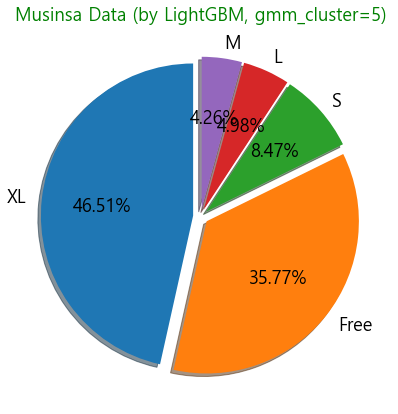

In [ ]:
#무신사 데이터 분류 결과
plt.figure(figsize=(7,7))

# pie chart 만들기(차트 띄우기, labels 달기, 각 조정, 그림자, 값 소숫점 표시)
plt.pie(musinsa_dress_brands['size(gmm5)'].value_counts(), labels=('XL', 'Free', 'S', 'L', 'M'), startangle=90, autopct='%.2f%%',
       explode=[0.05, 0.05, 0.05, 0.05, 0.05], shadow=True)

# 라벨, 타이틀 달기
plt.title('Musinsa Data (by LightGBM, gmm_cluster=5)', fontsize=18, color='g')

#plt.legend(['M','L', 'S', 'XL'], loc='upper right')

plt.rc('font', size=15)

plt.show()

#plt.savefig('SizeKorea_Data(cluster=4).png')
#plt.savefig('SizeKorea_Data(cluster=4).jpg')

## 13) 추천 시스템 생성
분류 결과를 바탕으로 추천

#### 모델 예상

In [ ]:
sizekorea_2020_gmm5 = sk_2020_gm5.copy()
sizekorea_2020_gmm5

,어깨너비,가슴단면,엉덩이단면,gmm_cluster5_labels,size(gmm5)
0,38.6,49.65,49.90,2,XL
1,37.5,40.90,46.10,1,S
2,39.5,41.95,44.70,4,M
3,36.6,43.35,46.40,0,Free
4,37.7,45.10,45.45,0,Free
...,...,...,...,...,...
2662,35.8,41.60,46.10,1,S
2663,40.0,39.45,43.35,1,S
2664,38.0,47.10,52.95,2,XL
2665,40.5,43.40,49.40,3,L


In [ ]:
musinsa_dress_brands

,brand_name,product_name,size,어깨너비,가슴단면,엉덩이단면,size(gmm5)
0,LIENLIER,로즈퍼프원피스 - 카키,xs,33.0,43.5,45.0,Free
1,LIENLIER,로즈퍼프원피스 - 카키,s,34.0,46.0,47.0,Free
2,LIENLIER,로즈퍼프원피스 - 카키,m,35.0,48.5,49.0,XL
3,AVANDRESS,Minimal Slim Dress BLACK,S,50.0,40.0,44.0,M
4,AVANDRESS,Minimal Slim Dress BLACK,M,51.0,41.0,45.0,M
...,...,...,...,...,...,...,...
1801,LIENLIER,로즈퍼프원피스 - 카키,s,34.0,46.0,47.0,Free
1802,LIENLIER,로즈퍼프원피스 - 카키,m,35.0,48.5,49.0,XL
1803,LIENLIER,로즈퍼프원피스 - 카키,xs,33.0,43.5,45.0,Free
1804,LIENLIER,로즈퍼프원피스 - 카키,s,34.0,46.0,47.0,Free


In [ ]:
### 사이즈 코리아 피실험자 임의로 한 명 설정
sample_ID = 983

### 사이즈 코리아 군집화 기반 사이즈 분류 확인
sample = sizekorea_2020_gmm5.iloc[sample_ID, :]
sample_size = sample[4]

### 피실험자의 사이즈에 해당하는 제품을 갖고 있는 브랜드 top 5 추출
### Musinsa Standard의 데이터 수가 너무 많아서 제외함
brand_got_sizes = musinsa_dress_brands[musinsa_dress_brands['size(gmm5)'] == sample_size]
top5_brands = brand_got_sizes.groupby('brand_name')[['product_name']].count().sort_values('product_name', ascending = False)[1:6]
top5_brands

,product_name
brand_name,
LANGNLU,13
ANGELO BIANCO,8
LUDE,7
WOVEMENT,6
MAU SOLEUM,6


In [ ]:
sample

어깨너비                    39.9
가슴단면                    38.0
엉덩이단면                  43.95
gmm_cluster5_labels        1
size(gmm5)                 S
Name: 983, dtype: object

In [ ]:
sample_size

'S'

In [ ]:
sample_size_li = [sample[0], sample[1], sample[2]]
sample_size_li

[39.900000000000006, 38.0, 43.95]

In [ ]:
musinsa_dress_brands[musinsa_dress_brands['size(gmm5)'] == sample_size]

,brand_name,product_name,size,어깨너비,가슴단면,엉덩이단면,size(gmm5)
7,AVANDRESS,Diagonal Slim Dress BLACK,FREE,35.5,41.0,38.0,S
8,AVANDRESS,Diagonal Slim Dress GREY,FREE,35.5,41.0,38.0,S
15,AVANDRESS,Diagonal Slim Dress KHAKI,FREE,35.5,41.0,38.0,S
19,NOT YOUR ROSE,소피아 드레스 (블랙),S,39.0,39.0,41.0,S
37,CITYPOPZ,[CP] 니트 슬림 피케 카라 롱원피스 [BLACK] 겨울 맥시 롱스커트 ver.,FREE,37.5,38.0,32.0,S
...,...,...,...,...,...,...,...
1753,MAU SOLEUM,반팔 브이넥 셔츠 원피스,M,39.0,41.0,43.0,S
1754,MAU SOLEUM,반팔 브이넥 셔츠 원피스,S,38.0,40.0,42.0,S
1755,MAU SOLEUM,반팔 브이넥 셔츠 원피스,M,39.0,41.0,43.0,S
1756,MAU SOLEUM,반팔 브이넥 셔츠 원피스,S,38.0,40.0,42.0,S


In [ ]:
### 피실험자의 신체 치수 추출 후 무신사 제품 치수 순서대로 배열
## 어깨너비, 가슴단면, 엉덩이단면 치수만
sample_size_li = [sample[0], sample[1], sample[2]]

### 피실험자의 사이즈에 해당하는 제품들 중 오차가 가장 적은 제품을 추천
## 같은 사이즈 제품 추출
same_size_products = musinsa_dress_brands[musinsa_dress_brands['size(gmm5)'] == sample_size]
same_size_products = same_size_products.reset_index().iloc[:, 1:]

## 각 제품들의 치수 오차 계산
es = []

for i in range(len(same_size_products)):
    e = 0
    
    e = e + abs(sample_size_li[0] - same_size_products['어깨너비'][i]) + \
    abs(sample_size_li[1] - same_size_products['가슴단면'][i]) + \
    abs(sample_size_li[2] - same_size_products['엉덩이단면'][i])
    
    es.append(e)

## 무신사 데이터에 오차 계산값 추가 후 
## 오차들의 합이 가장 적은 순서대로 정렬
## top 50 상품명 추출
same_size_products['difference'] = es

ordered_products = same_size_products.sort_values('difference')
ordered_products.loc[:, ['product_name', 'difference']][:50]

,product_name,difference
136,스트라이프 드레스_그리니시 옐로우,3.95
138,스트라이프 드레스_올리브,3.95
140,스트라이프 드레스_핑크,3.95
58,Napped Sweater Dress Black,4.05
63,2001 Dress,4.45
143,TWISTED STRIPE DRESS (PINK),4.85
144,TWISTED STRIPE DRESS (GREEN),4.85
152,반팔 브이넥 셔츠 원피스,4.85
5,소피아 드레스 (화이트),4.85
148,반팔 브이넥 셔츠 원피스,4.85


In [ ]:
size_korea_df = dt_2020_gm5.copy()

### * 상품 추천 함수 생성

In [ ]:
def brands_for_you(ID):
    ### 고객 ID 입력
    customer_ID = ID

    ### 사이즈 코리아 군집화 기반 사이즈 분류 확인
    customer_size = size_korea_df.iloc[customer_ID, :][?]

    ### 피실험자의 사이즈에 해당하는 제품을 갖고 있는 브랜드 top 5 추출
    ### Musinsa Standard의 데이터 수가 너무 많아서 제외함
    brand_got_sizes = musinsa_dress_df[musinsa_dress_df['size_pattern'] == customer_size]
    top5_brands = brand_got_sizes.groupby('brand_name')[['product_name']].count().sort_values('product_name', ascending = False)[1:6]
    TOP5 = [x for x in top5_brands.index]
    
    return TOP5

In [ ]:
def products_for_you(ID)   :
    ### 고객 ID 입력
    customer_ID = ID
    
    ### 사이즈 코리아 군집화 기반 사이즈 분류 확인
    customer = size_korea_df.iloc[customer_ID, :]
    customer_size = customer[-1]
    
    ### 피실험자의 신체 치수 추출 후 무신사 제품 치수 순서대로 배열
    customer_size_li = [customer[0], customer[1], customer[2]]

    ### 피실험자의 사이즈에 해당하는 제품들 중 오차가 가장 적은 제품을 추천
    ## 같은 사이즈 제품 추출
    same_size_products = musinsa_dress_df[musinsa_dress_df['size_pattern'] == customer_size]
    same_size_products = same_size_products.reset_index().iloc[:, 1:]

    ## 각 제품들의 치수 오차 계산
    es = []

    for i in range(len(same_size_products)):
        e = 0

        e = e + abs(customer_size_li[0] - same_size_products['어깨너비'][i]) + \
        abs(customer_size_li[1] - same_size_products['가슴단면'][i]) + \
        abs(customer_size_li[2] - same_size_products['엉덩이단면'][i])

        es.append(e)

    ## 무신사 데이터에 오차 계산값 추가 후 
    ## 오차들의 합이 가장 적은 순서대로 정렬
    ## top 50 상품명 추출
    same_size_products['difference'] = es

    ordered_products = same_size_products.sort_values('difference')
    top_products = ordered_products.loc[:, ['product_name', 'difference']][:50]
    TOP_PRODUCTS = top_products['product_name'].unique()
    
    return TOP_PRODUCTS